### Presentación del proyecto

## **Objetivo**

Los aerolíneas juegan un rol muy importante en los movimientos de viaje y relaciones a nivel global, tanto por motivos laborales o de ocio.

Las reseñas de éstas, se convirtieron en un estándar para orientar a los usuarios en la comparación al momento de elegir. Pero además, permiten a las aerolíneas, obtener un insight sobre la experiencia de los pasajeros, sus preferencias y el nivel de satisfacción en cada caso.
<br><br>


Con el acceso a herramientas e información que poseemos hoy en día, podemos categorizar miles de reseñas en etiquetas de sentimiento positivo, negativo, o neutral.

El objetivo es trabajar este conjunto de datos con reseñas en texto de diversas aerolíneas, junto a diversas calificaciones, generales de 1 a 9 (1 siendo muy negativo y 9 siendo muy positivo) y otras mas especificas como Precio-calidad, comodidad de asientos, etc. A partir de esta clasificación, al obtener una reseña nueva, se puede predecir si ésta es positiva o negativa.

### Contenido del dataset

#### Columnas

**Airline Name** = Nombre de la Aerolínea

**Overall Rating** = Calificación total

**Review Title** = Titulo de la reseña

**Review Date** = Fecha de la reseña

**Verified** = Si la reseña está verificada o no

**Review** = Texto de la reseña

**Aircraft** = Tipo de avión

**Type of Traveller** = Tipo de pasajero

**Seat Type** = Tipo de asiento

**Route** = Ruta de viaje

**Date Flown** = Fecha de vuelo

**Seat Comfort** = Calificación de comodidad del asiento

**Cabin Staff Service** = Calificación del staff de cabina

**Food & Beverages** = Calificación de la comida y bebida

**Ground Service** = Calificación del servicio en tierra

**Inflight Entertainment** = Calificación del entretenimiento en el vuelo

**Wifi & Connectivity** = Calificación de WiFi y conectividad

**Value for Money** = Calificación de relación precio/calidad

**Recommended** = Recomendado si/no


#### Citaciones

Recopilación por Juhi Bhojani y subido en Kaggle y Github

https://www.kaggle.com/datasets/juhibhojani/airline-reviews

https://github.com/Juhibhojani/Airline-Reviews-

Las reviews de aerolíneas de este dataset fueron obtenidas por el autor desde:

https://www.airlinequality.com/review-pages/a-z-airline-reviews/

### **Lectura de datos**

**Librerias necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import spacy

from collections import Counter
import re
from textblob import TextBlob
import string

#NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import ngrams

nltk.download('punkt')  # Tokenizers
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stop words
nltk.download('wordnet')  # WordNet lemmatizer
nltk.download('averaged_perceptron_tagger_eng')

#Sktools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn

from tqdm import tqdm
from transformers import AutoModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)                # Debe decir 11.8
print(torch.cuda.get_device_name(0))     # NVIDIA GeForce GTX 1060 6GB

True
11.8
NVIDIA GeForce GTX 1060 6GB


In [3]:
path = "https://raw.githubusercontent.com/Larrentawn/NLP-project/refs/heads/main/Airline_review.csv"
df = pd.read_csv(path, sep=",")

In [4]:
#!python -m spacy download en_core_web_sm

In [5]:
nlp = spacy.load("en_core_web_sm")

## **Análisis inicial**

In [6]:
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


Podemos observar algunos de los valores que tenemos en el dataset, asi como sus columnas. Algo que podemos ver a simple vista es que las fechas estan en formato escrito.

In [7]:
df.shape

(23171, 20)

In [8]:
df.describe()

,Unnamed: 0,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,23171.00000,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,11585.00000,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,6689.03588,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5792.50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,11585.00000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,17377.50000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,23170.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Vemos datos como la media y la desviación estandar.

In [9]:
df.dtypes

Unnamed: 0                  int64
Airline Name               object
Overall_Rating             object
Review_Title               object
Review Date                object
Verified                     bool
Review                     object
Aircraft                   object
Type Of Traveller          object
Seat Type                  object
Route                      object
Date Flown                 object
Seat Comfort              float64
Cabin Staff Service       float64
Food & Beverages          float64
Ground Service            float64
Inflight Entertainment    float64
Wifi & Connectivity       float64
Value For Money           float64
Recommended                object
dtype: object

Podemos ver varias cosas, los nombres de las columnas tienen mayúsculas, símbolos y espacios.

La columna **Overall Rating** es de tipo **object** en lugar de **int** o **float** y los de columna temporal que nos interesa **(Review Date)** es también de tipo object en lugar de **datetime**. También la variable de **Recommended** que es si/no.

In [10]:
pd.set_option('display.max_colwidth', None) #Visualizar el total del texto en la columna
df.describe(include="O").T

,count,unique,top,freq
Airline Name,23171,497,Aegean Airlines,100
Overall_Rating,23171,10,1,11595
Review_Title,23171,17219,Onur Air customer review,84
Review Date,23171,4557,16th July 2023,67
Review,23171,23046,CRL on Paris to Fort-de-France and return and my worst flights so far. The flight from ORY was delayed of 9 hours without any explanations. Then we had to wait for two hours in the plane after boarding (which was a rush). Their 747-300 are fit with 580 seats (90 more than AF) that's are very cramp and old. I was lucky enough to get a seat in the upper-deck just after the biz class so I had a lot of legroom available but this was the only attract of this flight. The food was horrible and the crew was very rude and only seemed to be interested in getting their break. The way back was horrible (although our flight was not delayed) because of an old 747-200 with even more cramped seats and rude flight attendants (some have even kept their sunglasses during the flight!). I hope no foreigners use this carrier because it doesn't give a good look of France.,2
Aircraft,7129,1048,A320,1041
Type Of Traveller,19433,4,Solo Leisure,7120
Seat Type,22075,4,Economy Class,19145
Route,19343,13607,Melbourne to Sydney,43
Date Flown,19417,109,June 2023,1057


Se puede ver más en profundidad las columnas de tipo **Object**, un conteo de valores unicos, el top y su frecuencia.

Vemos que las calificaciones **(overall_rating)** casi la mitad de los valores son 1, es decir posee muchisimas calificaciones negativas.

Las variables **type_of_traveller**, **seat_type** y **recommended** podrian ser codificadas en categorias numericas.
Tambien con la variable **overall_rating**.

In [11]:
df.describe(include=float).T

,count,mean,std,min,25%,50%,75%,max
Seat Comfort,19016.0,2.618374,1.464840,0.0,1.0,3.0,4.0,5.0
Cabin Staff Service,18911.0,2.871609,1.604631,0.0,1.0,3.0,4.0,5.0
Food & Beverages,14500.0,2.553586,1.526314,0.0,1.0,2.0,4.0,5.0
Ground Service,18378.0,2.353738,1.595747,1.0,1.0,1.0,4.0,5.0
Inflight Entertainment,10829.0,2.179056,1.488839,0.0,1.0,2.0,3.0,5.0
Wifi & Connectivity,5920.0,1.780405,1.318800,0.0,1.0,1.0,2.0,5.0
Value For Money,22105.0,2.451165,1.594155,0.0,1.0,2.0,4.0,5.0


Se procede a normalizar los nombres de las columnas

In [12]:
 df.columns = [col.replace(" ", "_").lower() for col in df.columns]
df.dtypes

unnamed:_0                  int64
airline_name               object
overall_rating             object
review_title               object
review_date                object
verified                     bool
review                     object
aircraft                   object
type_of_traveller          object
seat_type                  object
route                      object
date_flown                 object
seat_comfort              float64
cabin_staff_service       float64
food_&_beverages          float64
ground_service            float64
inflight_entertainment    float64
wifi_&_connectivity       float64
value_for_money           float64
recommended                object
dtype: object

In [13]:
df['overall_rating'].unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

En las calificaciones encontramos el valor 'n', el cual probablemente sea null.
Podemos ver un aproximado de donde podria ser alineada esta no-calificacion con algunos indicadores.


In [14]:
#Podemos leer algunas de las reseñas con este valor 'n'

df[df['overall_rating'] == 'n'][['review', 'overall_rating']].sample(5)

,review,overall_rating
18502,Perth to Exmouth. Very friendly crew and a good flight with the captain indulging in an overfly of Exmouth bay for a spot of whale watching!! Hot meal was supplied on the outward trip which was better than some other Carriers travelled. Highly recommended.,n
7641,Corsair A330-200 YUL-ORY / ORY-YUL. I didn't know what to expect from them as I had never taken any charter flight before. YUL-ORY. We took off 2 hours late because the aircraft arrived late from Paris. The flight was fine even though I was traumatized by how cramped the seats were. The crew was friendly and the food was good. ORY-YUL. Now that was a complete nightmare. We were supposed to takeoff at 11 am. We took of at 6 pm without any explanations. I had the emergency exit seat this time so the flight in itself was good. Will I ever fly again with them? only if I absolutely have too. I give them 4.5/5 out of 10.,n
14238,Have travelled Luxair (Dub-Man-Lux) several times to visit my daughter. I concur with previous comments - excellent and friendly service inflight what it used to be 20 years ago on other airlines.,n
4738,My wife and I had gone to Guernsey for a weekend so we could do the G-JOEY flight having seen voted best small airline by which magazine makes them look good. The weather was a bit poor and they do say if there is bad weather the flights might get cancelled so as is was awful we were not to sure if the flight would go ahead. Twenty minutes from departure the clouds broke up and sun started to appear which was a relief but then the flight got cancelled we were taken out of departures and that was it. We were told that according to the metro logical forecast the weather was not good but had Aurigny ops looked out of there window it was sunny and as we were only having a twenty minute trip on the plane And I saw no problem weather wise. However the truth came out accidentally let slip by a member of staff that the plane was needed for the 15.20 Alderney service to depart late at 15.55 which is why the trip was cancelled where as our schedule should have been a 15.45 departure. We were not the only passengers that had travelled from mainland Uk just for this flight and felt let down by the airline after paying to fly to Guernsey for the short flight. Having contacted the airline and no reply yet why they need twenty eight days to reply I will never know for a small airline sadly now I will possibly not get to fly this aircraft as it is due to come out of service.,n
7642,We went from Paris to Pointe à Pitre/Guadeloupe. Let alone the very poor ORLY airport's service (information desk not occupied no signs nobody wants to help you finding the right terminal). On the plane: Seats very cramped food poor films uninteresting. But as the seating space in AF to Réunion to which we are accustomed is not a bit better we took it. Our (direct) flight back was cancelled and brought forward by 3 hours what we learned by chance (!) reading a note on the hotel's pinboard. The plane was very untidy when we got in. And it was not a direct flight; we had a stop- over of a full hour in Fort-de-France (we had to leave the plane and amused ourselves in the duty- free shop) but at least the plane was cleaned there. Result: We started two hours earlier than we had planned and came back to Paris one hour later and were almost too late for our sequel flight from CDG to Frankfurt. Fortunately there seems to be an understanding between AF and Corsair and so even before we landed we were informed that we need not worry: AF was already informed about our delay (thank you staff!) and was willing to book us on the next flight which was eventually not necessary because we got our luggage early and caught the bus by running. Well as we saved 400 EUR for two persons on that flight in comparison to AF and as we know know what we possibly would have to expect we would try Corsair once again.,n


In [15]:
print(df.iloc[19541])

unnamed:_0                                                                                                                                                                                                                                                                                                                                                                                                                      19541
airline_name                                                                                                                                                                                                                                                                                                                                                                                                                SyrianAir
overall_rating                                                                                                                                              

Tambien podemos ver si respondió si recomendaría o no la aerolinea

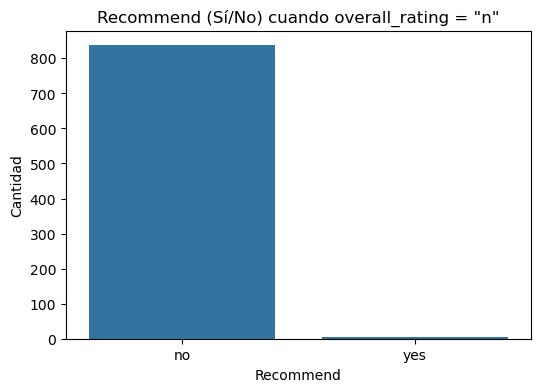

In [16]:
#Se filtra por respuesta 'n' en rating
df_overall_rating_n = df[df['overall_rating'] == 'n']

#Visualizacion de respuesta de recomienda si o no
plt.figure(figsize=(6,4))
sns.countplot(data=df_overall_rating_n, x='recommended')
plt.title('Recommend (Sí/No) cuando overall_rating = "n"')
plt.xlabel('Recommend')
plt.ylabel('Cantidad')
plt.show()


Vemos entonces que la mayoria de las 'n' serian tambien calificaciones negativas (1, 2, 3)

Procedemos a reemplazar 'n' con la mediana.

In [17]:
#Convertimos en numérico
df['overall_rating'] = pd.to_numeric(df['overall_rating'], errors='coerce')

#Calculamos la mediana
overall_rating_median = df['overall_rating'].median()
print(overall_rating_median)

1.0


In [18]:
#Reemplazamos los nulos con la mediana
df['overall_rating'].fillna(round(overall_rating_median), inplace=True)
df['overall_rating'] = df['overall_rating'].astype(int) #Convertimos a enteros

C:\Users\loren\AppData\Local\Temp\ipykernel_10576\757921108.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['overall_rating'].fillna(round(overall_rating_median), inplace=True)


In [19]:
#Verificamos los valores unicos
df['overall_rating'].unique()

array([9, 1, 8, 2, 3, 5, 6, 7, 4])

Se eliminan columnas irrelevantes

In [20]:
df.drop(["unnamed:_0", "aircraft","route","date_flown"], axis=1, inplace=True)

In [21]:
pd.set_option('display.max_colwidth', 50) #Visualizar el un maximo de 50 caracteres en el texto de la columna

Condicionales para ayudar en el formateo de la columna de fecha

In [22]:
df['review_date'] = [col.replace("nd","") if "nd" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("th","") if "th" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("st","") if "st" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("rd","") if "rd" in col else col for col in df['review_date'].values]

df['review_date'] = [col.replace("August","Augu") if "August" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("Augu","August") if "Augu" in col else col for col in df['review_date'].values]

df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date']

0       2019-11-11
1       2019-06-25
2       2019-06-25
3       2019-09-28
4       2019-09-24
           ...    
23166   2022-07-05
23167   2022-06-01
23168   2022-05-31
23169   2022-05-23
23170   2022-05-20
Name: review_date, Length: 23171, dtype: datetime64[ns]

In [23]:
# Verificación de nulos
df.isnull().sum()

airline_name                  0
overall_rating                0
review_title                  0
review_date                   0
verified                      0
review                        0
type_of_traveller          3738
seat_type                  1096
seat_comfort               4155
cabin_staff_service        4260
food_&_beverages           8671
ground_service             4793
inflight_entertainment    12342
wifi_&_connectivity       17251
value_for_money            1066
recommended                   0
dtype: int64

#### Verificación de duplicados

In [24]:
print(df.duplicated().sum())

120


In [25]:
#Se eliminan duplicados y se vuelve a verificar
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


## EDA

array([[<Axes: title={'center': 'overall_rating'}>,
        <Axes: title={'center': 'review_date'}>,
        <Axes: title={'center': 'seat_comfort'}>],
       [<Axes: title={'center': 'cabin_staff_service'}>,
        <Axes: title={'center': 'food_&_beverages'}>,
        <Axes: title={'center': 'ground_service'}>],
       [<Axes: title={'center': 'inflight_entertainment'}>,
        <Axes: title={'center': 'wifi_&_connectivity'}>,
        <Axes: title={'center': 'value_for_money'}>]], dtype=object)

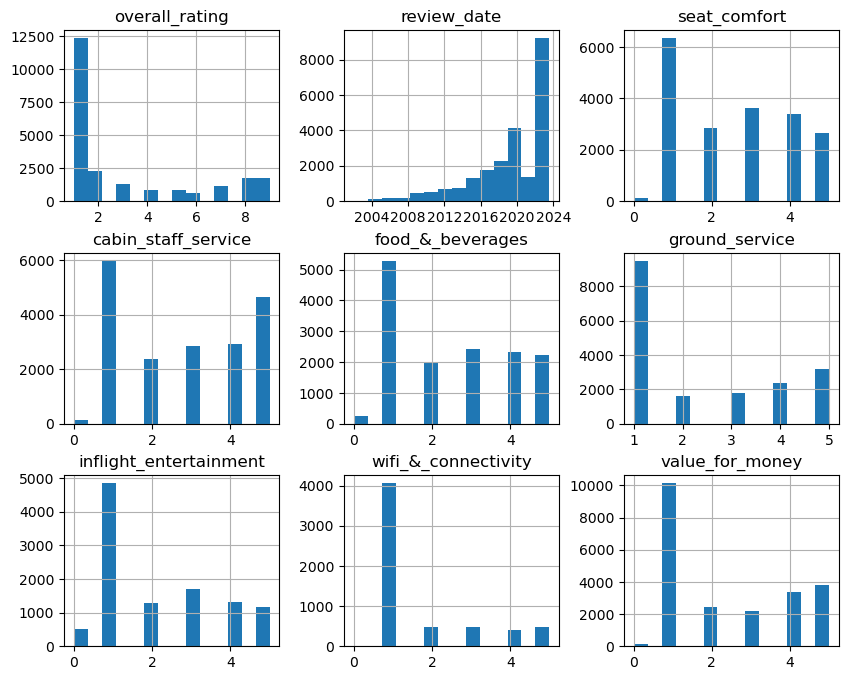

In [26]:
df.hist(figsize=[10,8], bins=14)

Vemos que hay una gran cantidad de reseñas fueron hechas en los ultimos años, y que hay muchas reseñas de 1 estrella en varias de las categorias.
La categoria de Staff y servicio de cabina es la que mas califcaciones positivas posee.

<Axes: title={'center': 'Distribucion de calificaciones totales'}, xlabel='overall_rating', ylabel='count'>

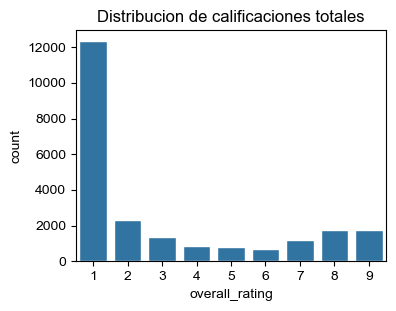

In [27]:
#Distribucion de calificaciones
plt.figure(figsize=(4,3))
plt.title("Distribucion de calificaciones totales")
sns.set_style("darkgrid")
sns.countplot(df,x='overall_rating')

<Axes: title={'center': 'Calificacion de precio-calidad por calificacion total'}, xlabel='overall_rating', ylabel='value_for_money'>

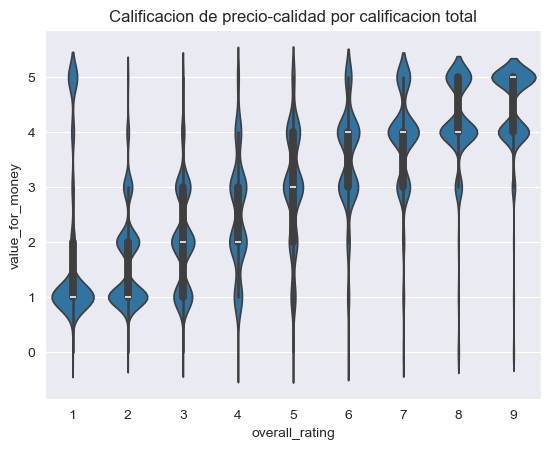

In [28]:
plt.title("Calificacion de precio-calidad por calificacion total")
sns.set_style("darkgrid")
sns.violinplot(df, x='overall_rating', y='value_for_money')

Observamos correlación en que a mayor calificacion relacion calidad-precio, mayor calificacion total. Hay una tendencia clara.

<Axes: title={'center': 'Distribucion de recomienda si/no'}, xlabel='recommended', ylabel='count'>

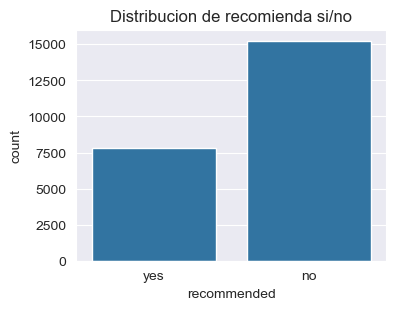

In [29]:
#Distribucion de recommended
plt.figure(figsize=(4,3))
plt.title("Distribucion de recomienda si/no")
sns.set_style("darkgrid")
sns.countplot(df,x='recommended')

In [30]:
# Conversion de la columna Recommended de Yes/no a 1 y 0 respectivamente
df["recommended"] = df["recommended"].map(dict(yes=1, no=0))
print(df[["recommended"]].head(20))

    recommended
0             1
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             1
10            0
11            0
12            0
13            0
14            0
15            1
16            0
17            0
18            1
19            0


In [31]:
# Selección de columnas numéricas y de texto

df_num = df[["overall_rating", "review_date", "verified",
"seat_comfort", "cabin_staff_service", "food_&_beverages",
"ground_service", "inflight_entertainment", "wifi_&_connectivity", "value_for_money", "recommended"]]

df_text = df[["review", "type_of_traveller", "seat_type"]]

In [32]:
print(df.columns)

Index(['airline_name', 'overall_rating', 'review_title', 'review_date',
       'verified', 'review', 'type_of_traveller', 'seat_type', 'seat_comfort',
       'cabin_staff_service', 'food_&_beverages', 'ground_service',
       'inflight_entertainment', 'wifi_&_connectivity', 'value_for_money',
       'recommended'],
      dtype='object')


In [33]:
df['airline_name'].value_counts().reset_index()

,airline_name,count
0,Aegean Airlines,100
1,Aer Lingus,100
2,Norwegian,100
3,Oman Air,100
4,Onur Air,100
...,...,...
492,TUIfly Nordic,1
493,Air Labrador,1
494,Air Costa,1
495,Air Cote d'Ivoire,1


In [34]:
# Recuento de cantidad de reviews por aerolinea
df['airline_review_count'] = df.groupby('airline_name')['airline_name'].transform('count')
df[['airline_name', 'airline_review_count']].drop_duplicates().sort_values('airline_review_count', ascending=False)

,airline_name,airline_review_count
94,Aegean Airlines,100
194,Aer Lingus,100
15209,Norwegian,100
15426,Oman Air,100
15537,Onur Air,100
...,...,...
21076,TUIfly Nordic,1
2077,Air Labrador,1
1481,Air Costa,1
1482,Air Cote d'Ivoire,1


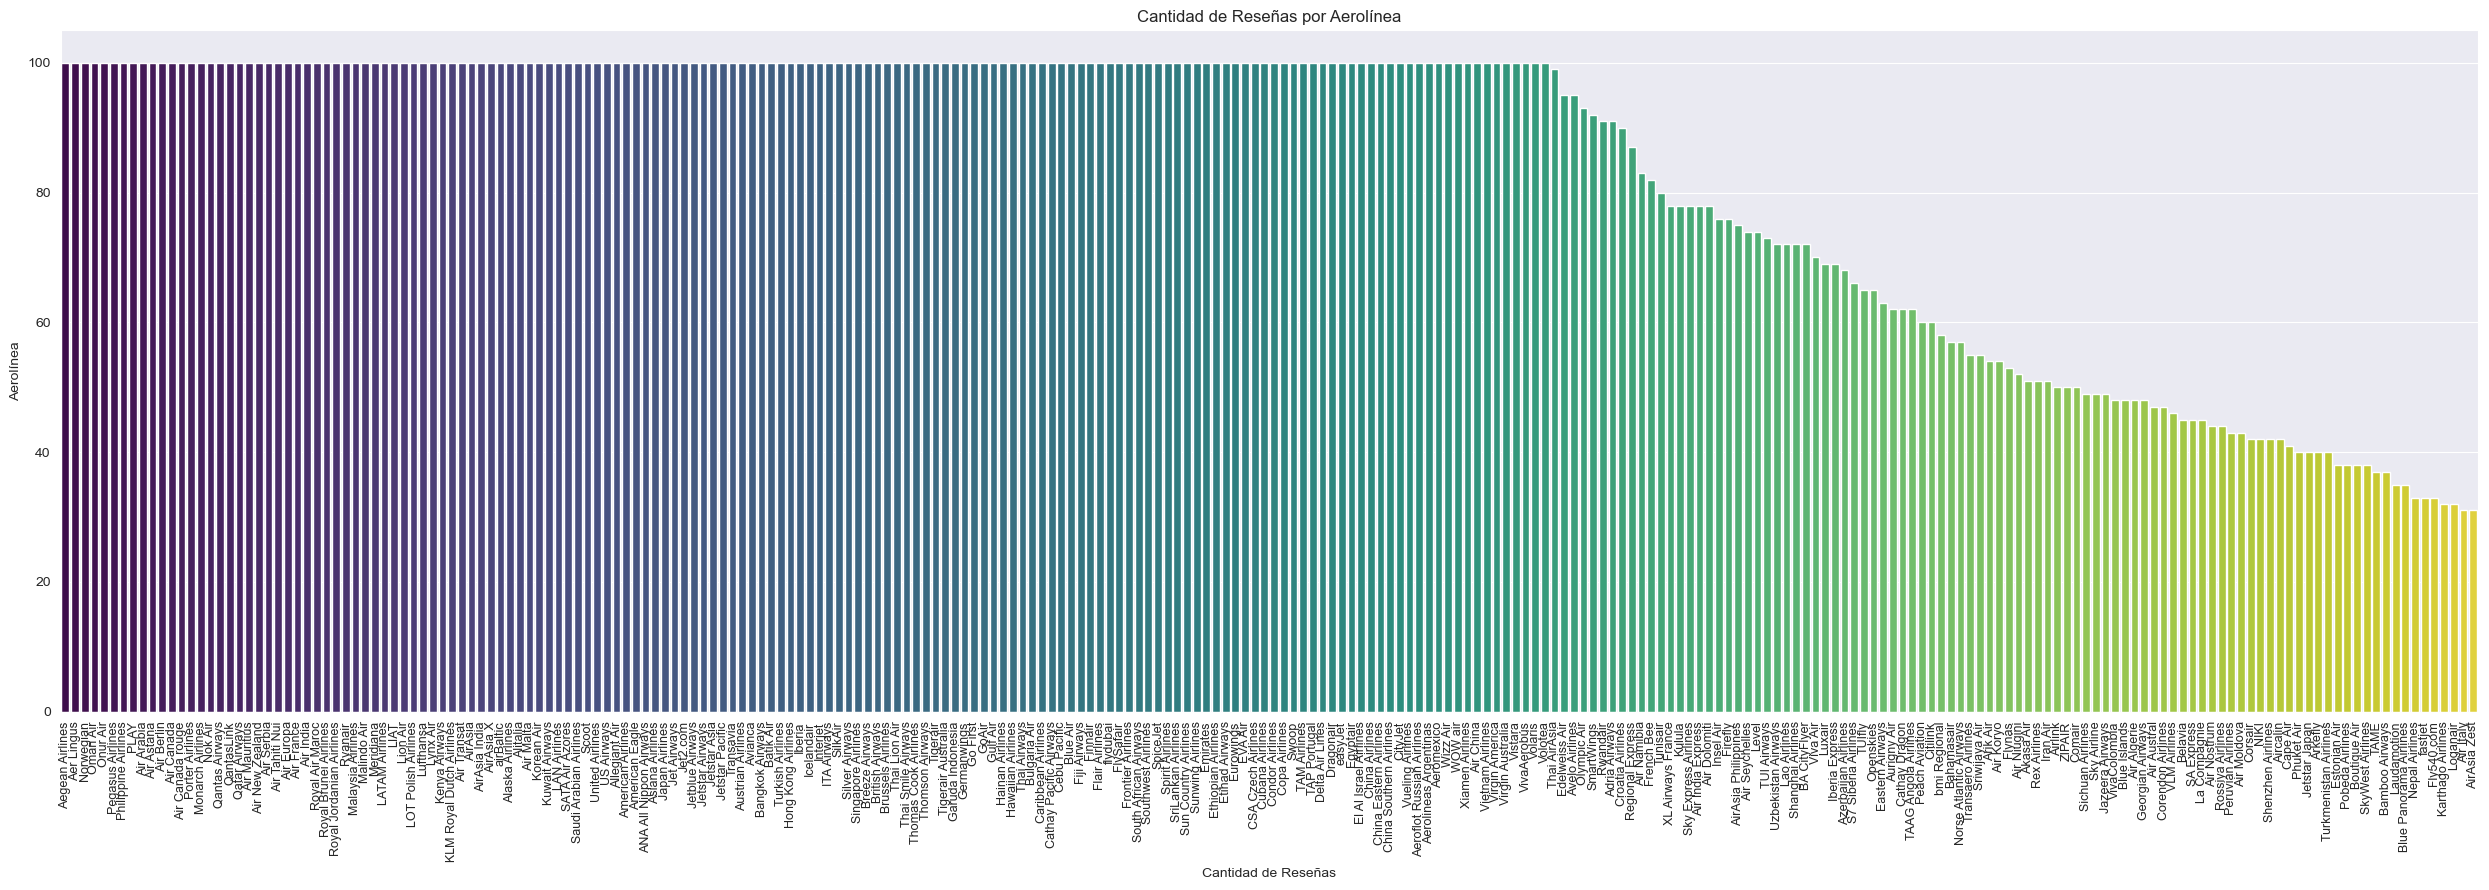

In [35]:
# Visualizacion del recuento de reviews por aerolinea (top 250)

df_airlines = df['airline_name'].value_counts().head(250).reset_index()
df_airlines.columns = ['airline_name', 'airline_review_count']

plt.figure(figsize=(25, 9))
sns.barplot(data=df_airlines, y='airline_review_count', x='airline_name', palette='viridis', hue='airline_name', legend=False)
plt.xticks(rotation=90, fontsize=9)

plt.title('Cantidad de Reseñas por Aerolínea')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Aerolínea')
plt.tight_layout()
plt.show()

Vemos que las primeras 150 aerolineas poseen 100 reseñas cada una,, y luego va en disminución.

In [36]:
df_name_rev_count = df.groupby("airline_name").mean(numeric_only=True).drop(columns=["airline_review_count"]).reset_index()
df_name_rev_count

,airline_name,overall_rating,verified,seat_comfort,cabin_staff_service,food_&_beverages,ground_service,inflight_entertainment,wifi_&_connectivity,value_for_money,recommended
0,AB Aviation,3.666667,1.000000,2.666667,2.666667,2.000000,2.000000,NaN,NaN,2.333333,0.333333
1,ANA All Nippon Airways,3.750000,0.840000,4.281250,4.604167,4.177778,4.193878,3.988235,4.125000,4.110000,0.780000
2,ASKY Airlines,2.304348,0.391304,2.142857,1.857143,1.941176,1.555556,1.090909,1.000000,1.565217,0.130435
3,ATA Airlines,1.500000,0.000000,1.000000,1.500000,1.500000,1.500000,NaN,NaN,2.000000,0.000000
4,Adria Airways,4.087912,0.131868,3.392857,3.428571,2.627907,3.051282,1.718750,1.900000,2.942857,0.472527
...,...,...,...,...,...,...,...,...,...,...,...
492,euroAtlantic Airways,2.062500,0.562500,1.375000,1.875000,2.307692,1.625000,1.538462,1.666667,1.437500,0.125000
493,fastjet,2.878788,0.363636,3.000000,2.928571,2.125000,2.290323,1.285714,1.000000,2.272727,0.303030
494,flyadeal,1.894737,0.842105,1.600000,1.666667,1.857143,1.333333,1.000000,1.000000,1.736842,0.052632
495,flybe,1.250000,1.000000,3.333333,4.333333,4.500000,3.500000,NaN,NaN,3.250000,0.500000


In [37]:
# merge de los dos dataframes con el recuento de aerolineas y los ratings
df_summ = pd.merge(
    df_airlines,
    df_name_rev_count,
    how="inner",
    on='airline_name')
df_summ.head()

,airline_name,airline_review_count,overall_rating,verified,seat_comfort,cabin_staff_service,food_&_beverages,ground_service,inflight_entertainment,wifi_&_connectivity,value_for_money,recommended
0,Aegean Airlines,100,3.02,0.80,2.806452,3.225806,2.822785,2.606383,2.515152,2.666667,2.49,0.34
1,Aer Lingus,100,2.18,0.58,2.255319,2.500000,1.910256,1.842105,2.131148,1.625000,1.90,0.13
2,Norwegian,100,2.43,0.81,2.696203,2.848101,2.420000,2.392857,2.536585,2.750000,2.38,0.32
3,Oman Air,100,2.89,0.82,3.396825,3.333333,3.186441,3.046875,3.277778,1.950000,2.45,0.35
4,Onur Air,100,3.65,0.09,1.982143,2.125000,1.698113,1.352941,0.812500,1.000000,2.84,0.37


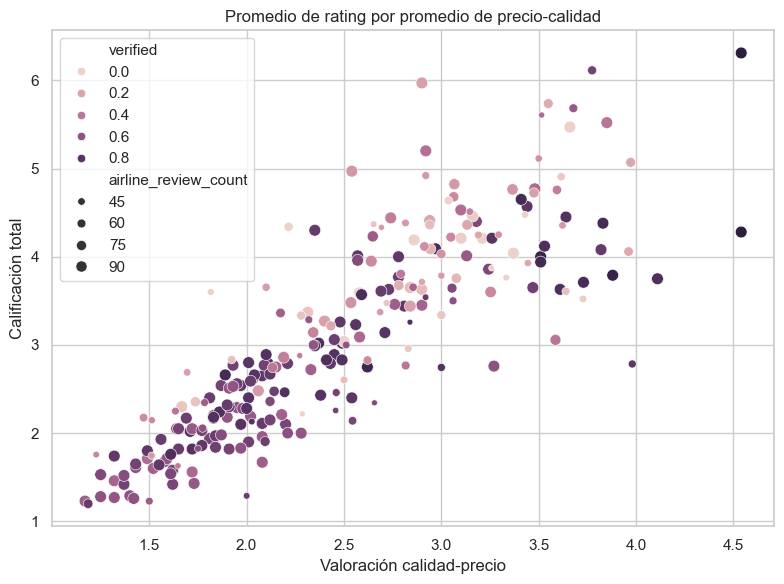

In [38]:
# Visualización de los ratings y la calificacion de precio-calidad
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(8,6))
sns.scatterplot(df_summ, x="value_for_money", y="overall_rating",
                 size='airline_review_count', hue='verified')
plt.title("Promedio de rating por promedio de precio-calidad")
plt.xlabel('Valoración calidad-precio')
plt.ylabel('Calificación total')
plt.tight_layout()
plt.show()

Vemos en mayor detalle la correlación que existe entre la calificacion promedio de cada aerolinea y el promedio de calificacion calidad-precio.
La cantidad de reseñas se puede ver con el tamaño de cada circulo y el color indica cuantas de esas reseñas estan verificadas por el sitio.

<Axes: title={'center': 'Calificacion de precio-calidad por calificacion total'}, xlabel='recommended', ylabel='overall_rating'>

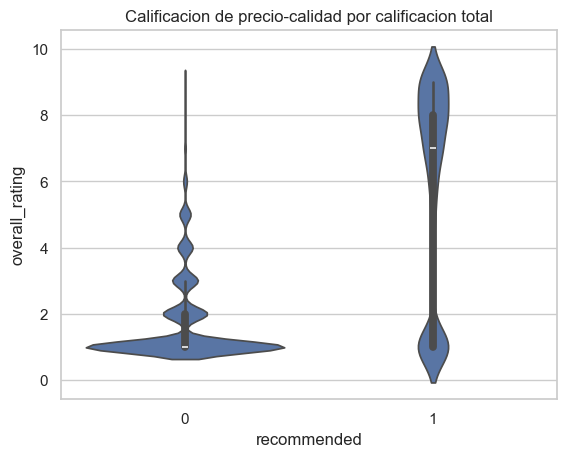

In [39]:
plt.title("Calificacion de precio-calidad por calificacion total")
sns.set_style("darkgrid")
sns.violinplot(df, y='overall_rating', x='recommended')

Vemos tambien una relacion entre la calificacion total y la recomendacion o no recomendacion de la aerolinea

In [40]:
df_num = df_num.drop(columns=["review_date"])
print(df_num.columns)
print(df_num.columns.names)

Index(['overall_rating', 'verified', 'seat_comfort', 'cabin_staff_service',
       'food_&_beverages', 'ground_service', 'inflight_entertainment',
       'wifi_&_connectivity', 'value_for_money', 'recommended'],
      dtype='object')
[None]


<Axes: >

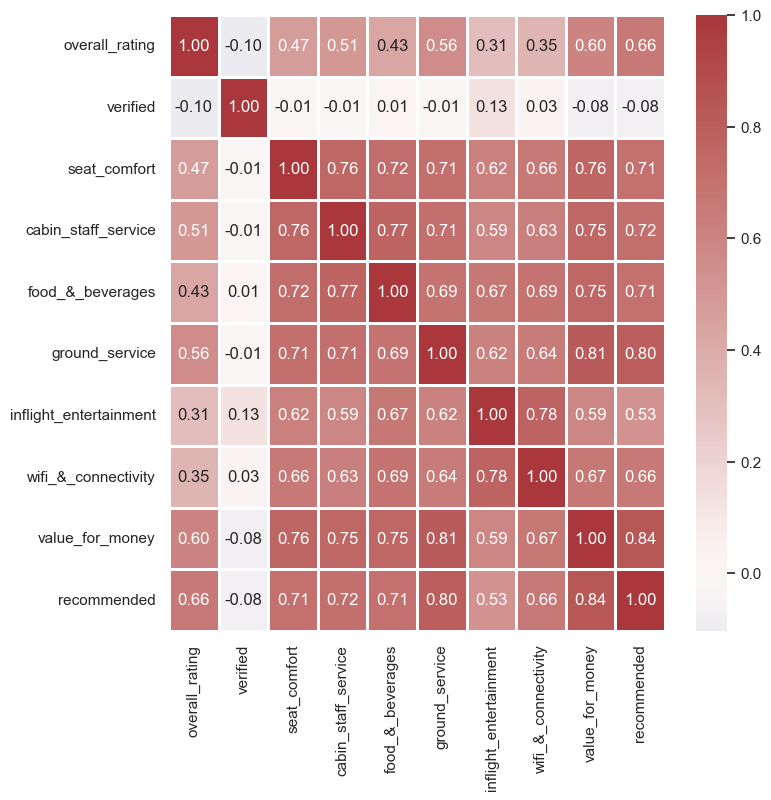

In [41]:
corr = df_num.corr()

used_columns = df_num.columns[df_num.columns.isin(corr.columns)]

df_corr = df_num[used_columns]
corr_matrix = df_corr.corr()

# Graficar con números
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=.75)


Vemos en la matriz de correlaciones que la mayor correlacion se puede encontrar entre value_for_money (precio-calidad), y recommended. Tambien entre otras calificaciones de servicio en aeropuerto y value_for_money.

# **Análisis y preprocesamiento del Texto**

#### **Longitud de las Oraciones**

In [42]:
print(df["review"].dropna().iloc[0])

  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.


In [43]:
df["review"] = df["review"].fillna("")

# Funcion para contar la cantidad de oraciones
def longitud_oraciones(text):
    try:
        oraciones = sent_tokenize(text)
        if not oraciones:
            return pd.Series([0, 0])
        len_oraciones = [len(word_tokenize(sent)) for sent in oraciones]
        return pd.Series([len(oraciones), sum(len_oraciones) / len(len_oraciones)])
    except:
        return pd.Series([0, 0])

# Aplicamos la función a cada review
df[["num_sentences", "avg_sentence_length"]] = df["review"].apply(longitud_oraciones)

In [44]:
#Vemos la cantidad de oraciones en cada review
df[["num_sentences"]]

,num_sentences
0,5.0
1,12.0
2,6.0
3,10.0
4,5.0
...,...
23166,8.0
23167,9.0
23168,6.0
23169,36.0


In [45]:
#Promedio de oraciones en las reviews
df[["num_sentences"]].mean()

num_sentences    8.388183
dtype: float64

In [46]:
# Promedio de largo de cada oracion (en palabras)
df['avg_sentence_length']

0        14.600000
1        12.416667
2        12.833333
3        14.200000
4        26.000000
           ...    
23166    20.375000
23167    17.888889
23168    29.666667
23169    18.583333
23170    14.750000
Name: avg_sentence_length, Length: 23051, dtype: float64

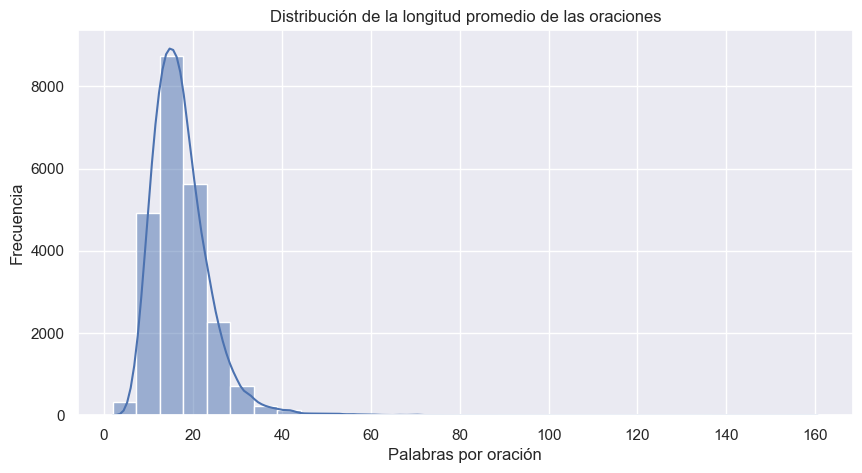

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(df["avg_sentence_length"], bins=30, kde=True)
plt.title("Distribución de la longitud promedio de las oraciones")
plt.xlabel("Palabras por oración")
plt.ylabel("Frecuencia")
plt.show()

Vemos que la moda se encuentra entre las 15 y 20 palabras por oración.

#### **Frecuencia de Palabras**

In [48]:
# Se concatena todas las reviews en un texto

text = " ".join(df["review"].dropna().astype(str))

# Tokenizar
tokens = word_tokenize(text.lower())  # pasar a minusculas

# Quitar puntuaciones, numeros y stopwords
stop_words = set(stopwords.words("english"))
tokens_cleaned = [
    word for word in tokens
    if word.isalpha() and word not in stop_words
    ]

In [49]:
# Contar frecuencia
freq_palabras = Counter(tokens_cleaned)

top_palabras = freq_palabras.most_common(40)

print(top_palabras)

[('flight', 42353), ('airline', 12761), ('service', 12697), ('time', 12305), ('us', 9495), ('would', 9413), ('one', 8499), ('airport', 8465), ('staff', 8382), ('hours', 7912), ('flights', 7564), ('get', 7509), ('plane', 7204), ('seats', 6862), ('good', 6850), ('crew', 6799), ('air', 6676), ('seat', 6525), ('food', 6430), ('even', 6413), ('airlines', 6123), ('could', 5875), ('back', 5813), ('fly', 5754), ('told', 5751), ('luggage', 5643), ('customer', 5539), ('check', 5455), ('never', 5274), ('experience', 5254), ('cabin', 5230), ('boarding', 5080), ('passengers', 4916), ('hour', 4806), ('delayed', 4627), ('first', 4576), ('got', 4422), ('ticket', 4368), ('return', 4198), ('another', 4081)]


C:\Users\loren\AppData\Local\Temp\ipykernel_10576\2544126640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_frec, x="frequency", y="word", palette="Blues_d")


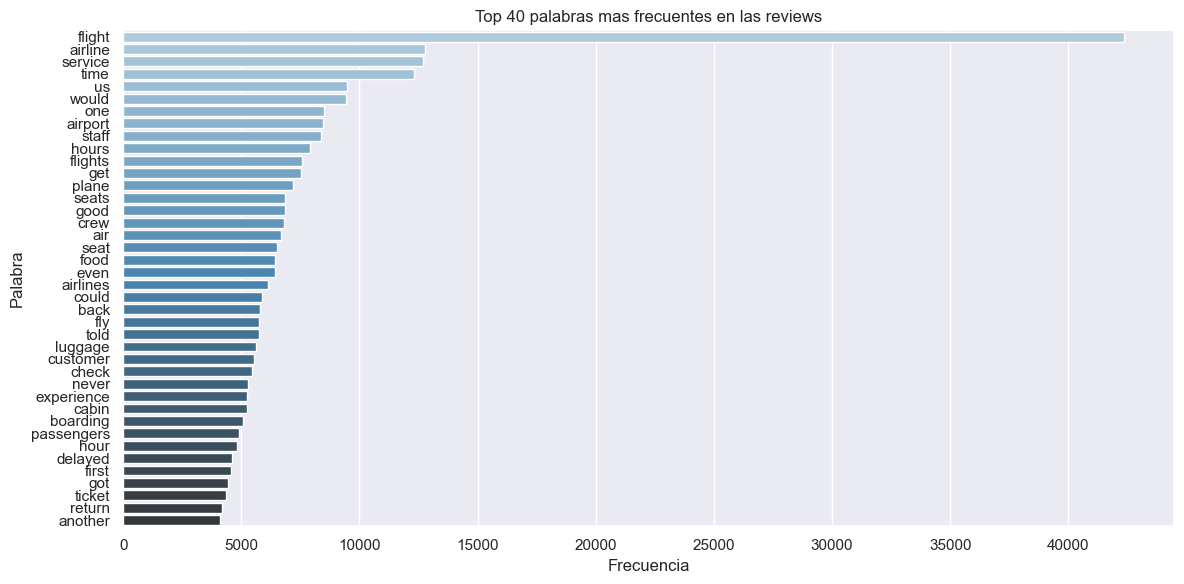

In [50]:
# se convierte la frecuencia de las palabras a un DF para graficar
df_frec = pd.DataFrame(top_palabras, columns=["word", "frequency"])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_frec, x="frequency", y="word", palette="Blues_d")
plt.title("Top 40 palabras mas frecuentes en las reviews")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()

Vemos el top de palabras mas usadas: **Flight, airline, service y time** de las mas comunes entendiblemente. Luego hay algunas interesantes, **hours**, **never, delayed, return, another** , que parece que se refieren a los problemas que son explayados en las reviews.

#### **Partes del Discurso (POS)**

In [51]:
tagged_tokens = pos_tag(tokens)
# Agrupar por tipo
pos_counts = Counter(tag for word, tag in tagged_tokens)

print(pos_counts.most_common(20))

[('NN', 636770), ('IN', 340343), ('DT', 283332), ('JJ', 253360), ('VBD', 197265), ('RB', 194072), ('.', 190288), ('VB', 152151), ('PRP', 138579), ('NNS', 135409), ('CC', 119151), ('TO', 109006), (',', 80546), ('VBN', 76251), ('CD', 64572), ('VBP', 62513), ('PRP$', 57217), ('VBG', 57099), ('VBZ', 43158), ('MD', 34177)]


C:\Users\loren\AppData\Local\Temp\ipykernel_10576\2381405872.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x="Count", y="POS", palette="viridis")


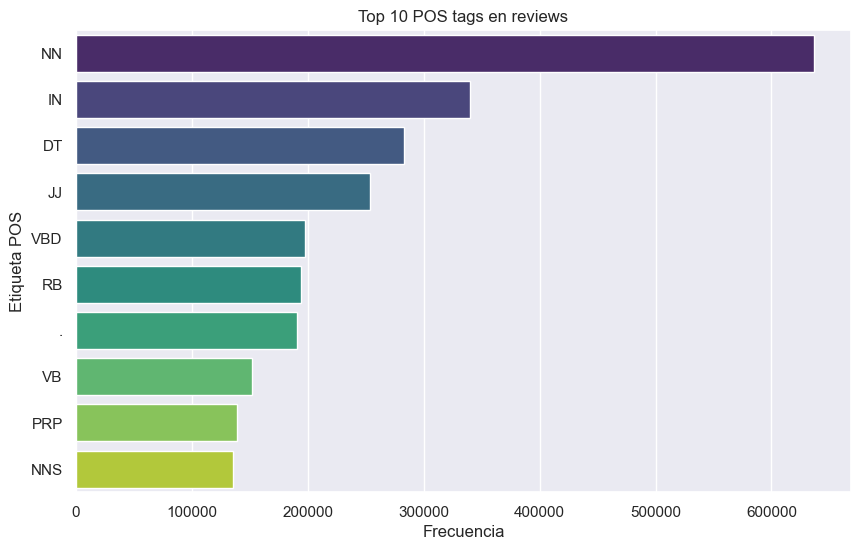

In [52]:
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "Count"])
pos_df = pos_df.sort_values(by="Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_df, x="Count", y="POS", palette="viridis")
plt.title("Top 10 POS tags en reviews")
plt.xlabel("Frecuencia")
plt.ylabel("Etiqueta POS")
plt.show()

Vemos que los tipos de palabras mas comunes son los sustantivos en primer lugar, luego los articulos o preposiciones, luego los adjetivos y luego los verbos en pasado.

#### **Distribución de Longitud de Palabras**

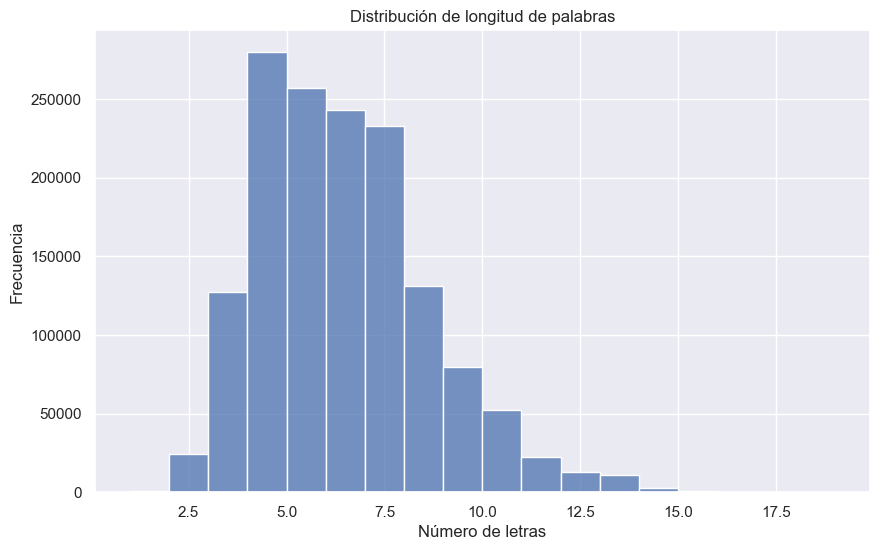

In [53]:
word_lengths = [len(word) for word in tokens_cleaned]

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=range(1, 20), kde=False)
plt.title("Distribución de longitud de palabras")
plt.xlabel("Número de letras")
plt.ylabel("Frecuencia")
plt.show()

#### **Análisis de N-gramas**

In [54]:
# Bigramas
bigramas = list(ngrams(tokens_cleaned, 2))
bigramas_freq = Counter(bigramas).most_common(20)

# Trigramas
trigramas = list(ngrams(tokens_cleaned, 3))
trigramas_freq = Counter(trigramas).most_common(20)

print("Top 10 Bigramas:")
for par in bigramas_freq[:10]:
    print(par)

print("\nTop 10 Trigramas:")
for trio in trigramas_freq[:10]:
    print(trio)


Top 10 Bigramas:
(('customer', 'service'), 3984)
(('cabin', 'crew'), 2463)
(('business', 'class'), 2294)
(('flight', 'delayed'), 1664)
(('return', 'flight'), 1434)
(('flight', 'attendants'), 1304)
(('even', 'though'), 1034)
(('connecting', 'flight'), 1030)
(('flight', 'cancelled'), 1006)
(('never', 'fly'), 968)

Top 10 Trigramas:
(('worst', 'airline', 'ever'), 462)
(('flight', 'delayed', 'hours'), 339)
(('worst', 'customer', 'service'), 214)
(('cabin', 'crew', 'friendly'), 209)
(('worst', 'experience', 'ever'), 204)
(('never', 'fly', 'airline'), 187)
(('first', 'time', 'flying'), 180)
(('ho', 'chi', 'minh'), 175)
(('flight', 'next', 'day'), 160)
(('low', 'cost', 'airline'), 153)


Aquí podemos ver los bigramas y trigamas que mas frecuencia tienen en las reviews.

Notamos que en este caso los bigramas mas comunes suelen ser sustantivos, y los trigramas mas comunes suelen ser descriptivos de la experiencia (por lo visto mayormente negativas).

#### **Análisis de la Diversidad Léxica**

La diversidad lexica seria la cantidad de palabras unicas dividido la cantidad de palabras totales, para analizar que tan variado es el vocabulario, o si suelen ser palabras comunes y repetidas.

In [55]:
palabras_totales = len(tokens_cleaned)
palabras_unicas = len(set(tokens_cleaned))
diversidad_lexica = palabras_unicas / palabras_totales

print(f"Diversidad léxica: {diversidad_lexica:.3f}")

Diversidad léxica: 0.020


La diversidad de 0.020 es muy baja, por lo que suelen ser palabras comunes y repetidas.

A partir de un valor de 0.3 suele ser mas variado, y de mas de 0.7 es muy variado.

#### **Visualización de Palabras con Word Cloud**

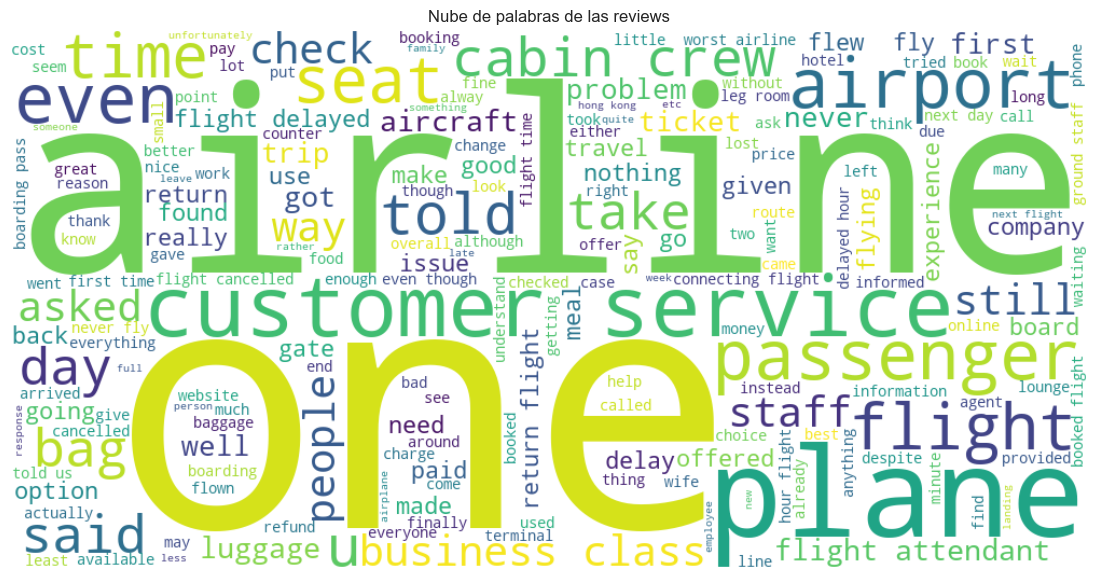

In [56]:
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(" ".join(tokens_cleaned))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras de las reviews")
plt.show()

#### **Conclusiones del Analisis exploratorio**

Podemos concluir a partir de este analisis, lo siguiente

*   La longitud promedio de las oraciones de las reviews ronda entre **15 y 20 palabras.**
*   Un promedio de 8.33 oraciones por review.

*   Hay bastantes palabras utilizadas muchas veces, pero pocas utilizadas muchisimas veces: ('flight', 42353), ('airline', 12761), ('service', 12697), ('time', 12305).
*   Los **bigramas** mas utilizados, son menciones: (('customer', 'service'), 3984)
(('cabin', 'crew'), 2463)
(('business', 'class'), 2294)


*   Y los **trigramas** mas utilziados son mas descriptivos: (('worst', 'airline','ever'), 462)
(('flight', 'delayed', 'hours'), 339)
(('worst', 'customer', 'service'), 214)
(('cabin', 'crew', 'friendly'), 209)

    Estos muestran aspectos clave que los pasajeros valoran o critican.



*   Se pueden ver temas recurrentes, las reviews se centran mayormente en servicio, comodidad y puntualidad.

### **Análisis Sintáctico**

Podemos ver las relaciones sintacticas en las frases, el tipo de palabra y su relacion con otras.

In [57]:
review = df['review'].iloc[422]
doc = nlp(review)

# Mostrar estructura de las frases
for token in doc:
    print(f"{token.text:<15} {token.pos_:<10} {token.dep_:<15} {token.head.text}")

                SPACE      dep             Horrible
Horrible        ADJ        amod            service
service         NOUN       nsubj           supposed
,               PUNCT      punct           service
flight          NOUN       appos           service
from            ADP        prep            flight
Buenos          PROPN      compound        Aires
Aires           PROPN      pobj            from
to              ADP        prep            flight
Rio             PROPN      compound        Janeiro
de              PROPN      compound        Janeiro
Janeiro         PROPN      pobj            to
supposed        VERB       ROOT            supposed
to              PART       aux             depart
depart          VERB       xcomp           supposed
at              ADP        prep            depart
18:20           NUM        pobj            at
on              ADP        prep            depart
the             DET        det             31st
31st            NOUN       pobj            on
May 

### **Análisis Semántico**

Por ejemplo de una review positiva:

In [58]:
print(df["review"].iloc[0])

  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.


In [59]:
review_pos = df['review'].iloc[0]
blob = TextBlob(review_pos)
print(f"Polaridad: {blob.sentiment.polarity}, Subjetividad: {blob.sentiment.subjectivity}")

Polaridad: 0.3022222222222222, Subjetividad: 0.6261111111111112


La polaridad (de -1.0 a +1.0) indica que tan negativa (-1.0) o positiva (+1.0) es. Y la subjetividad (de 0 a 1) indica la objetividad (0.0) a subjetividad (1.0)

Un ejemplo de review negativa:

In [60]:
print(df["review"].iloc[18293])

  Horrible Customer Service! I booked extra luggage by accident and I wanted to cancel it. I called 5 times and was on hold for forever to get someone to speak too. I asked about a refund and they just said there is nothing they can do. Flight: old propeller plane, uncomfortable seats and the flight attendants didn’t assure Covid safety on board. They looked away to not see people take off their masks. And the flight was delayed also!


In [61]:
review_neg = df['review'].iloc[18293]
blob = TextBlob(review_neg)
print(f"Polaridad: {blob.sentiment.polarity}, Subjetividad: {blob.sentiment.subjectivity}")

Polaridad: -0.38125, Subjetividad: 0.575


En este caso la review siendo la review negativa da una polaridad de -0.38.

### Lematización

In [62]:
print(tokens_cleaned[0:21])

['moroni', 'moheli', 'turned', 'pretty', 'decent', 'airline', 'online', 'booking', 'worked', 'well', 'checkin', 'boarding', 'fine', 'plane', 'looked', 'well', 'maintained', 'short', 'flight', 'minutes', 'expect']


In [63]:
texts = df["review"].fillna("").tolist()

lemmatized = []
# Iteracion para pasar las reviews
for doc in nlp.pipe(texts, batch_size=1000):
    lemmas = [tokens_cleaned.lemma_ for tokens_cleaned in doc if not tokens_cleaned.is_punct and not tokens_cleaned.is_stop]
    lemmatized.append(" ".join(lemmas))

df["review_lemmatized"] = lemmatized

### **Codificación de texto a vectores**

#### Tf-Idf

In [64]:
reviews = df['review'].dropna().astype(str)

# Tokenizer para mantener palabras alfabeticas
def clean_tokenizer(text):
    return re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())

# se instancia el TF-IDF
tfidf = TfidfVectorizer(tokenizer=clean_tokenizer, stop_words='english', max_df=0.95, min_df=5)

# se aplica una variable X
X_tfidf = tfidf.fit_transform(reviews)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

print(tfidf_df.head())

c:\Users\loren\.conda\envs\ds\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


    aa        ab  ababa  aback  abandon  abandoned  abbotsford  aber  \
0  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
1  0.0  0.255136    0.0    0.0      0.0        0.0         0.0   0.0   
2  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
3  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
4  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   

   aberdeen  abide  ...  zim  zimbabwe  zip  zipair  zone  zones  zoo  zrh  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   

    zu  zurich  
0  0.0     0.0  
1  0.0     0.0  
2  0.0     0.0  
3  0.0     0.0  
4  0.0     0.

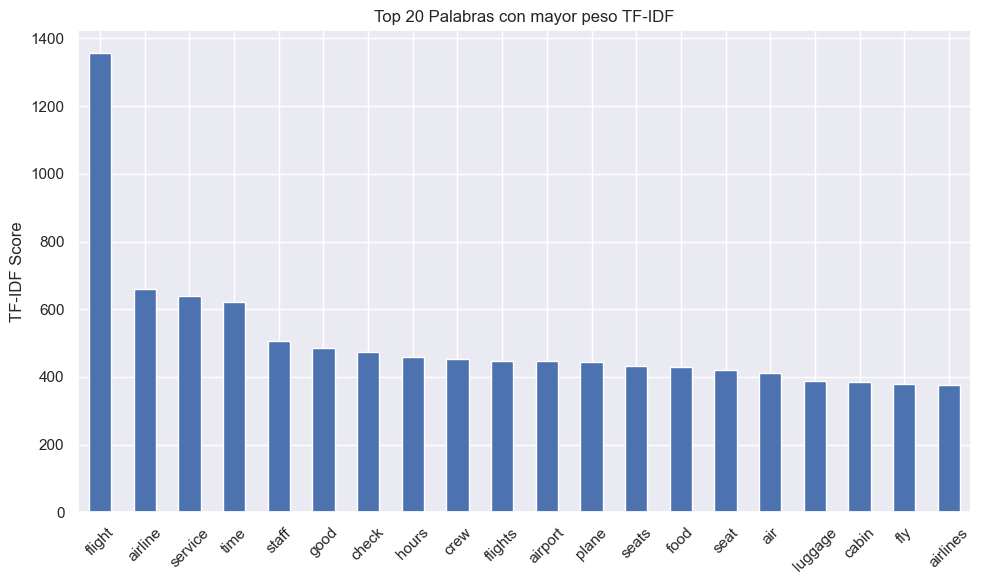

In [65]:
# Puntajes TF-IDF por palabra en todo el corpus
puntajes_tf = tfidf_df.sum().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
puntajes_tf.head(20).plot(kind='bar')
plt.title("Top 20 Palabras con mayor peso TF-IDF")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El TF-IDF evalua el peso de las palabras en el contexto en el que están. Muchas son coincidentes con las palabras mas utilziadas

# Feature Selection

In [66]:
df = df.dropna(subset=['review', 'overall_rating'])

**Selección de variable objetivo y variables independientes**

In [67]:
pd.set_option('display.max_colwidth', None) #
df_rating_5 = df.loc[df['overall_rating'] == 5]
df_rating_5[['overall_rating','recommended','value_for_money','review']].head(5)

,overall_rating,recommended,value_for_money,review
25,5,0,1.0,"Fly only if no other connection, I am a frequent business flyer mostly departing from Vienna or Munich to destinations. The flight with Adria was chosen due to convenience, however if I had an option to choose next time, the value for money is not there nor the experience. Outdated aircraft (buzzing from AC in the upper compartment present the whole time of descending and extremly anoying. Complimentary glass of water and snack (pretzles). Other options only upon payment (does not seem acceptable fot the price over 400 eur). Not to mention online check in unavailable from Paris, while the traffic to the airport is unpredictable, hence online check in is a must. All in all I would fly Adria again only if there is no other option left. The aircraft staff though very nice."
36,5,0,2.0,"Ljubljana to Amsterdam in Adria Airways Economy class. No free snacks or even drinks, which is very sad for a Star Alliance partner, because their fare prices are high but offer is similar to low cost airlines. Beverages which they sell in their ""Air shop"" looks nice on advert, beautiful pictures, but when you buy it, you get small sandwich with bad taste. I figured out It's better to buy a sandwich in airport caffe, than onboard."
39,5,0,3.0,"Frankfurt to Ljubljana with Adria Airways. Boarding was on-time, but aircraft was parked on remote gate about 15 minutes from main terminal. So we departed about 25 minutes late. Service onboard was poor, with no complimentary drinks or snacks - they are available only for sale. Arrival was 15 minutes later than scheduled. Crew was friendly."
48,5,1,3.0,I had flights from Paris to Sarajevo via Ljubljana. Adria Airways provides a low cost product these days. The food and beverages become for purchase including water. This is acceptable for short flights but it should be clearly indicated during the ticket purchase on their web-site. There are no hot options and quality of sandwiches is really poor. Besides the service was very friendly and efficient. Both flights arrived on time.
57,5,1,4.0,Return flight Paris-Skopje via Ljubljana. All flights were on time and nice very clean planes / good flight crew. Seats were comfortable enough for a 1-2 hours flight. Boarding was easy for all flights. Ljubljana airport is very small and nice. The only downside is the absence of any snack. FA served only water and coffee/tea. This is almost like low cost airline. It is recommended airline for short flights.


Utilizando Overall_rating como variable target. En primera instancia probaría como positivo un valor mayor de 5, y negativo como menor que 5 inclusive.
Teniendo en cuenta de solo tomar las que tengan tambien recommended 1.

In [68]:
df['overall_rating'] = df['overall_rating'].astype(float)

#Se define la calificacion a binario, positivo solo si overall rating es mayor o igual a 5 y recommended es 'si'
df['label'] = np.where((df['overall_rating'] >= 4) & (df['recommended'] == 1), 1, 0)

# variables x
X_lem = df['review_lemmatized']

df['text'] = df['review']
X = df['text']

# target
y = df['label']

In [69]:
X

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [70]:
df['label'].value_counts()

label
0    17605
1     5446
Name: count, dtype: int64

La cantidad de reviews negativas quedo en 16836 y la cantidad de positivas en 6215. Un desbalance que puede afectar al modelo.

# **Modelos**

**División de datos en conjuntos de entrenamiento y prueba**

In [71]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_lem, y, test_size=0.2, random_state=42)

In [72]:
X_train[0:26]

14257            spend half time 5 day week different airport Luxair monopole Luxembourg alternative flight Germany Frankfurt Berlin Munich exist choice enormous business class correct little airline french champagne little delicious sandwich salad 4 different wine choice sweet cake cream landing excellent chocolate Luxembourg hand find Business Lounge operate Luxair great compare one Paris Munich Frankfurt special flair familiar atmosphere especially new lounge add terminal modern get impression expose contrary Luxair`s Fokker 50 minimum standard quality old extremely noisy small interior bad condition especially seat try avoid new erj-145 comfortable seat cover leather offer good space seat speed Boeing 737 spare time fly Luxair charter flight destination like Las Palmas Sharm El Sheik Madeira etc notice huge lost quality flight cold meal disgusting easy define sandwich freeze stop offer alcohol wine beer cabin crew look like tired friendly little change result special character nati

In [73]:
# Vectorizacion de las variables X.
tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,
    min_df=5,
    ngram_range=(1, 3)  # Usa unigramas, bigramas y trigramas
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Balanceo de clases

Al tener una diferencia tan grande entre reviews positivas y negativas hay que hacer un resampling para balancear la cantidad de reviews positivas y negativas, asi el modelo se entrena correctamente.

In [74]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_tfidf, y_train)

In [75]:
Counter(y_resampled)

Counter({0: 14096, 1: 14096})

Vemos ahora que las variables target tienen la misma cantidad de valores 0 y 1

Aunque SMOTE no es ideal para el tipo de datos que tenemos, ya que los vectores que genera para balancear las clases, son inventados y puede que tengan poca relación con un metodo mas "real".
Por lo que opté por utilizar el class_weight 'balanced' de los modelos, y el scale_pos_weight del xgb.

## Regresion Logistica

In [76]:
# Regresion logistica
clf = LogisticRegression(C=1, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, class_weight='balanced')

**Evaluación del rendimiento del modelo**

In [77]:
# Evaluación
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3509
           1       0.61      0.83      0.70      1102

    accuracy                           0.83      4611
   macro avg       0.77      0.83      0.79      4611
weighted avg       0.86      0.83      0.84      4611



**Predicción con conjunto de prueba**

In [78]:
review_nueva = ["The flight was comfortable and the staff were very friendly."]

# Convertir la review a vector
X_new = tfidf.transform(review_nueva)

# Prediccion
prediction = clf.predict(X_new)
proba = clf.predict_proba(X_new)

print("Predicción:", "Positiva" if prediction[0] == 1 else "Negativa")
print("Probabilidad:", proba[0])

Predicción: Positiva
Probabilidad: [0.14029042 0.85970958]


Vemos que la predicción dio una probabilidad de 0.08 de que sea negativa, y una
probabilidad de 0.91 de que sea positiva.

In [79]:
test_reviews = [
    "The flight was delayed and the food was terrible.",
    "Fantastic service and very smooth check-in process.",
    "Seats were okay, nothing special.",
    "Terrible flight, rude staff, and broken seats.",
    "One of the best flights I’ve had in years!"
]

# Transformar con el mismo vectorizador TF-IDF
X_test_reviews = tfidf.transform(test_reviews)

# Obtener predicciones y probabilidades
predictions = clf.predict(X_test_reviews)
probabilities = clf.predict_proba(X_test_reviews)

# Mostrar resultados
for review, pred, proba in zip(test_reviews, predictions, probabilities):
    sentiment = "Positiva" if pred == 1 else "Negativa"
    confidence = proba[1] if pred == 1 else proba[0]

    print(f"📝 Review: {review}")
    print(f"🔮 Predicción: {sentiment} (Confianza: {confidence:.2f})")
    print("-" * 60)

📝 Review: The flight was delayed and the food was terrible.
🔮 Predicción: Negativa (Confianza: 0.83)
------------------------------------------------------------
📝 Review: Fantastic service and very smooth check-in process.
🔮 Predicción: Positiva (Confianza: 0.62)
------------------------------------------------------------
📝 Review: Seats were okay, nothing special.
🔮 Predicción: Positiva (Confianza: 0.59)
------------------------------------------------------------
📝 Review: Terrible flight, rude staff, and broken seats.
🔮 Predicción: Negativa (Confianza: 0.90)
------------------------------------------------------------
📝 Review: One of the best flights I’ve had in years!
🔮 Predicción: Negativa (Confianza: 0.69)
------------------------------------------------------------


In [80]:
#Optimizacion de Regresion logistica
clf_params = {
    'C': [ 1,3,5,15],
    'class_weight': [None, 'balanced']
}

grid_clf = GridSearchCV(LogisticRegression(), clf_params, cv=5, scoring='f1',verbose=2)
grid_clf.fit(X_train_tfidf, y_train)

print("Best params:", grid_clf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.1s
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.1s
[CV] END .........................C=1, class_weight=balanced; total time=   0.0s
[CV] END .........................C=1, class_weight=balanced; total time=   0.0s
[CV] END .........................C=1, class_weight=balanced; total time=   0.0s
[CV] END .........................C=1, class_weight=balanced; total time=   0.0s
[CV] END .........................C=1, class_weight=balanced; total time=   0.0s
[CV] END .............................C=3, class_weight=None; total time=   0.2s
[CV] END .............................C=3, class_

In [81]:
rl_report = classification_report(y_test, y_pred)
print()

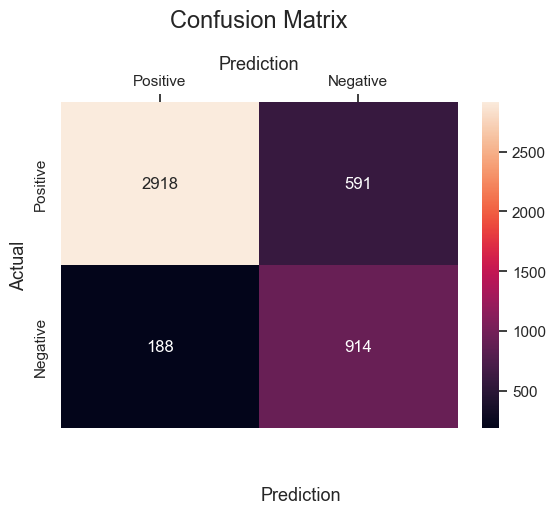

In [82]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

**Conclusión sobre el modelado y las metricas**

La regresión logistica dio un resultado bastante aceptable en primera instancia, con una precisión, 0.8 aprox
Pero con un recall bajo (58%), el modelo no identifica bien las reviews positivas.

F1-score general: aceptable, pero mejorable.

## Random Forest Classifier

In [83]:
rf_clf = RandomForestClassifier(random_state=42,
                                class_weight='balanced',
                                max_depth=None,
                                max_features='sqrt',
                                min_samples_leaf=2,
                                min_samples_split=5,
                                n_estimators=150)
rf_clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=150, random_state=42)

In [84]:
# Evaluación
y_pred = rf_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      3509
           1       0.62      0.74      0.68      1102

    accuracy                           0.83      4611
   macro avg       0.77      0.80      0.78      4611
weighted avg       0.84      0.83      0.84      4611



In [85]:
review_nueva = ["The flight was comfortable and the staff were very friendly."]

# Convertir la review a vector
X_new = tfidf.transform(review_nueva)

# Prediccion
prediction = rf_clf.predict(X_new)
proba = rf_clf.predict_proba(X_new)

print("Predicción:", "Positiva" if prediction[0] == 1 else "Negativa")
print("Probabilidad:", proba[0])

Predicción: Positiva
Probabilidad: [0.29671037 0.70328963]


In [86]:
# Optimizacion de Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [1, 2 , 3],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt'],     # Qué proporción de features usar
    'class_weight': ['balanced'] 
}


grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-2,           # "-1" = Todos los nucleos. "-2" = Todos los nucleos menos uno.
    scoring='f1',
    verbose=2
)
grid_search_rf.fit(X_train_tfidf, y_train)

print("Mejores parámetros:", grid_search_rf.best_params_)
print("Mejor puntaje F1:", grid_search_rf.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\loren\.conda\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\loren\.conda\envs\ds\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\loren\.conda\envs\ds\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\loren\.conda\envs\ds\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\loren\.conda\

Mejores parámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntaje F1: 0.6829067630184961


In [87]:
new_reviews = [
    "Amazing flight experience, very smooth and clean.",
    "Worst flight I've ever had, very rude staff."
    "The flight was delayed and the food was terrible.",
    "Fantastic service and very smooth check-in process.",
    "Seats were okay, nothing special.",
    "Terrible flight, rude staff, and broken seats.",
    "One of the best flights I’ve had in years!"
]

best_rf = grid_search_rf.best_estimator_

# Evaluar
y_pred = best_rf.predict(X_test_tfidf)
rf_report = classification_report(y_test, y_pred)
print(rf_report)

X_new = tfidf.transform(new_reviews)
preds = best_rf.predict(X_new)
probas = best_rf.predict_proba(X_new)

for review, pred, proba in zip(new_reviews, preds, probas):
    label = "Positiva" if pred == 1 else "Negativa"
    print(f"📝 {review}")
    print(f"🔮 {label} (Confianza: {proba[pred]:.2f})\n")

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      3509
           1       0.59      0.81      0.68      1102

    accuracy                           0.82      4611
   macro avg       0.76      0.82      0.78      4611
weighted avg       0.85      0.82      0.83      4611

📝 Amazing flight experience, very smooth and clean.
🔮 Positiva (Confianza: 0.64)

📝 Worst flight I've ever had, very rude staff.The flight was delayed and the food was terrible.
🔮 Negativa (Confianza: 0.74)

📝 Fantastic service and very smooth check-in process.
🔮 Positiva (Confianza: 0.54)

📝 Seats were okay, nothing special.
🔮 Negativa (Confianza: 0.58)

📝 Terrible flight, rude staff, and broken seats.
🔮 Negativa (Confianza: 0.79)

📝 One of the best flights I’ve had in years!
🔮 Negativa (Confianza: 0.65)



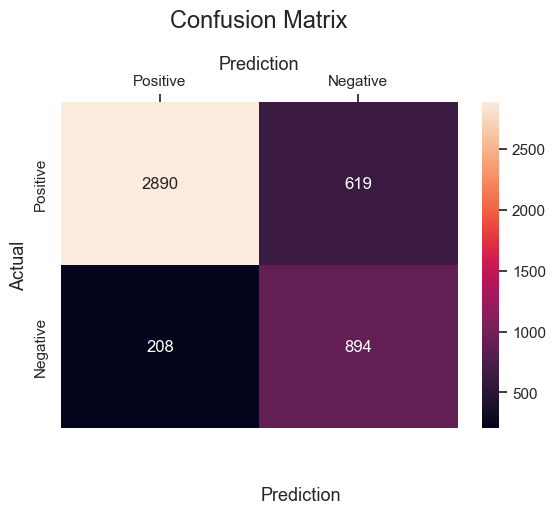

In [88]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

## XGBoost

In [89]:
scale = np.float64(2.7214934409687186)

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale,
    use_label_encoder=False,
    random_state=42,
    n_estimators=150,
    n_jobs=-2,
    learning_rate=0.2,
    max_depth=None,
    max_leaves=3,
    device='cuda',
    predictor='gpu_predictor')

xgb.fit(X_train_tfidf, y_train)

# Evaluación
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

c:\Users\loren\.conda\envs\ds\lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3509
           1       0.61      0.83      0.70      1102

    accuracy                           0.83      4611
   macro avg       0.77      0.83      0.79      4611
weighted avg       0.86      0.83      0.84      4611



In [90]:
# Grid de parametros

param_grid_xgb = {
    'device': ['cuda'],
    'n_estimators': [ 150 ,200],
    'max_depth': [ 3, 5, 7, None],
    'max_leaves': [1,2,5,7],
    'learning_rate': [0.05,0.1],
    'scale_pos_weight': [scale],
    'use_label_encoder': [False, True]
}

# GridSearch
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring=make_scorer(f1_score, average='binary'),
    n_jobs=-2,
    cv=5,
    verbose=3
)

# Entrenamiento
grid_xgb.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 128 candidates, totalling 640 fits


c:\Users\loren\.conda\envs\ds\lib\site-packages\xgboost\training.py:183: UserWarning: [17:48:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrai...
                                     multi_strategy=None, n_estimators=150,
                                     n_jobs=-2, num_parallel_tree=None, ...),
             n_jobs=-2,
             param_grid={'device': ['cuda'], 'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, 7, None],
                         'max_leaves': [1, 2, 5, 7], 'n_estimators': [150, 200],
                         'scale_pos_weight': [np.float64(2.7214934409687186)],
                         'use_label_encoder': [False, True]},
             scoring=make_scorer(f1_score, response_method='predict', average=binary),
             verbose=3)

In [91]:
print("Mejores parámetros:", grid_xgb.best_params_)

best_model = grid_xgb.best_estimator_

# Evaluar
y_pred = best_model.predict(X_test_tfidf)
xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

Mejores parámetros: {'device': 'cuda', 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 2, 'n_estimators': 150, 'scale_pos_weight': np.float64(2.7214934409687186), 'use_label_encoder': False}
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3509
           1       0.48      0.45      0.47      1102

    accuracy                           0.75      4611
   macro avg       0.66      0.65      0.65      4611
weighted avg       0.75      0.75      0.75      4611



c:\Users\loren\.conda\envs\ds\lib\site-packages\xgboost\core.py:729: UserWarning: [17:48:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [92]:
new_reviews = [
    "Amazing flight experience, very smooth and clean.",
    "Worst flight I've ever had, very rude staff."
    "The flight was delayed and the food was terrible.",
    "Fantastic service and very smooth check-in process.",
    "Seats were okay, nothing special.",
    "Terrible flight, rude staff, and broken seats.",
    "One of the best flights I’ve had in years!"
]

X_new = tfidf.transform(new_reviews)
preds = best_model.predict(X_new)
probas = best_model.predict_proba(X_new)

for review, pred, proba in zip(new_reviews, preds, probas):
    label = "Positiva" if pred == 1 else "Negativa"
    print(f"📝 {review}")
    print(f"🔮 {label} (Confianza: {proba[pred]:.2f})\n")

📝 Amazing flight experience, very smooth and clean.
🔮 Negativa (Confianza: 0.66)

📝 Worst flight I've ever had, very rude staff.The flight was delayed and the food was terrible.
🔮 Negativa (Confianza: 0.66)

📝 Fantastic service and very smooth check-in process.
🔮 Negativa (Confianza: 0.66)

📝 Seats were okay, nothing special.
🔮 Negativa (Confianza: 0.66)

📝 Terrible flight, rude staff, and broken seats.
🔮 Negativa (Confianza: 0.66)

📝 One of the best flights I’ve had in years!
🔮 Negativa (Confianza: 0.66)



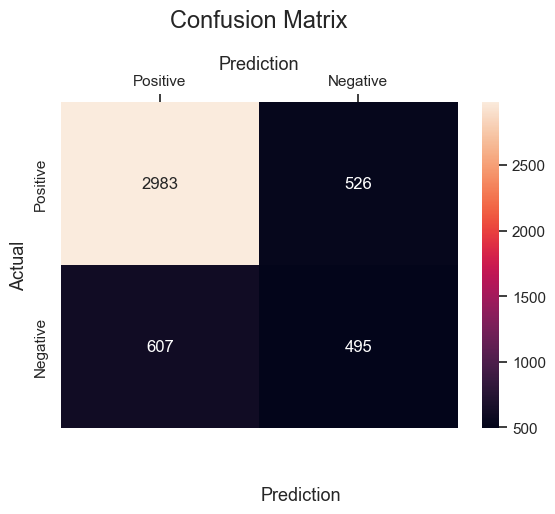

In [93]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

## DistillBERT

In [94]:
#!pip install transformers datasets -q

In [95]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertModel
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold

import os
os.environ["WANDB_DISABLED"] = "true"

In [96]:
# Armado de DataFrames con las muestras de X e y train_test_split
'''train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
'''
## train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Armado de DataFrames con las muestras para StratifiedKFold
train_df = pd.DataFrame({'text': X, 'label': y})
test_df = pd.DataFrame({'text': X, 'label': y})

In [97]:
pd.set_option('display.max_colwidth', 180)
train_df

,text,label
0,"Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short f...",1
1,Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the of...,0
2,Anjouan to Dzaoudzi. A very small airline and the only airline based in Comoros. Check-in was disorganised because of locals with big packages and disinterested staff. The fl...,0
3,"Please do a favor yourself and do not fly with Adria. On the route from Munich to Pristina in July 2019 they lost my luggage and for 10 days in a row, despite numerous phone ...",0
4,"Do not book a flight with this airline! My friend and I should have returned from Sofia to Amsterdam on September 22 and 3 days before, they sent us an SMS informing the fligh...",0
...,...,...
23166,"Bangkok to Tokyo. I’ve flown many low cost airlines before, but they still served meals, offered beverages, and just had more general information. The flight attendants were t...",0
23167,Avoid at all costs. I booked flights to go from Singapore to Tokyo and due to unforeseen circumstances I have been really unwell and aren’t allowed to fly. I reached out to z...,0
23168,Flight was leaving at 23.15 and after an hour and a half flying had to get back to airport due to a medical emergency of a passenger. Upon landing we were left inside the pla...,0
23169,"Zipair is JAL’s budget airline. They don’t have classes of travel, you just pick your seat (flat bed, emergency exit etc) and pay accordingly. We usually travel BA or JAL busi...",1


In [98]:
print(f"Shape de train_df: {train_df.shape}")
print(train_df['label'].value_counts())

Shape de train_df: (23051, 2)
label
0    17605
1     5446
Name: count, dtype: int64


In [99]:
print(train_df['text'])

0          Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short f...
1         Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the of...
2          Anjouan to Dzaoudzi. A very small airline and the only airline based in Comoros. Check-in was disorganised because of locals with big packages and disinterested staff. The fl...
3          Please do a favor yourself and do not fly with Adria. On the route from Munich to Pristina in July 2019 they lost my luggage and for 10 days in a row, despite numerous phone ...
4         Do not book a flight with this airline! My friend and I should have returned from Sofia to Amsterdam on September 22 and 3 days before, they sent us an SMS informing the fligh...
                                                       

In [100]:
#  Cross-validation StratifiedKFold

original_df = train_df.copy()

NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['text'], train_df['label'])):
    print(f"\n🔁 Fold {fold + 1}/{NUM_FOLDS}")

    # Usás estos como siempre en tu flujo
    train_df = original_df.iloc[train_idx].reset_index(drop=True)
    test_df = original_df.iloc[val_idx].reset_index(drop=True)


🔁 Fold 1/5

🔁 Fold 2/5

🔁 Fold 3/5

🔁 Fold 4/5

🔁 Fold 5/5


In [101]:
print(f"Shape de train_df: {train_df.shape}")
print(train_df['label'].value_counts())

Shape de train_df: (18441, 2)
label
0    14084
1     4357
Name: count, dtype: int64


In [102]:
print(f"Shape de test_df: {test_df.shape}")
print(test_df['label'].value_counts())

Shape de test_df: (4610, 2)
label
0    3521
1    1089
Name: count, dtype: int64


In [103]:
train_df

,text,label
0,"Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short f...",1
1,Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the of...,0
2,Anjouan to Dzaoudzi. A very small airline and the only airline based in Comoros. Check-in was disorganised because of locals with big packages and disinterested staff. The fl...,0
3,"Please do a favor yourself and do not fly with Adria. On the route from Munich to Pristina in July 2019 they lost my luggage and for 10 days in a row, despite numerous phone ...",0
4,"Do not book a flight with this airline! My friend and I should have returned from Sofia to Amsterdam on September 22 and 3 days before, they sent us an SMS informing the fligh...",0
...,...,...
18436,Terrible experience with customer service on this airline. Given it is required to get a visa to travel to Japan and you have to be part of an organized tour we were denied a...,0
18437,"Bangkok to Tokyo. I’ve flown many low cost airlines before, but they still served meals, offered beverages, and just had more general information. The flight attendants were t...",0
18438,Avoid at all costs. I booked flights to go from Singapore to Tokyo and due to unforeseen circumstances I have been really unwell and aren’t allowed to fly. I reached out to z...,0
18439,"Zipair is JAL’s budget airline. They don’t have classes of travel, you just pick your seat (flat bed, emergency exit etc) and pay accordingly. We usually travel BA or JAL busi...",1


In [104]:
test_df.sample(10)

,text,label
456,I flew Air Memphis Luxor to Abu Simbel on a very ancient Romanian built BAC 111. Frightening on way out even worse when we landed back at Luxor - we were still deplaning onto a...,0
3957,We have booked flight to Chumpon for a big group of over 20 person since early last year but was cancelled due to Covid19 epidemic. Therefore we have to postpone flight to Oct...,0
2593,Flew from Lanseria 10 minutes from home simple check-in in under 30 seconds flights on time entertaining crew overall a pleasant experience. I could not fault Kulula or the air...,0
669,Gold Coast to Kuala Lumpur. No inflight entertainment. Seats are rock hard and sit too upright. Absolutely freezing so make sure you bring a coat as they charge you for a bla...,0
949,It’s cheap. The employees must be bound by strict policies because they seem like nice people. It’s ridiculously not customer friendly. I’m on a mostly empty flight but to sw...,0
1613,Aberdeen to Leeds. Once again a flight cancellation of the evening flight due operational reasons. Only 3 passengers on flight so cancelled and flown to Newcastle and taxi to...,0
2489,My friends and I chose to fly from Shanghai to Tokyo with Jetstar and it was a big mistake. They cancelled our flight on the last minute because of bad weather conditions. Af...,0
1669,"It is 4th time in a row . And every flight had a delay. We missed our transfer at Tanzania. And no responsible to communicate. No staff speaks English, also in check in the w...",0
2006,"Paris to San Francisco. I purchased a ticket using someone else’s card, which the site allowed me to do 2-3 weeks before my flight. I was never notified that I needed to upda...",0
3703,PRG-CDG on Nov-05 departure 6 AM. First experience with this Czech- based low cost carrier. Swift check-in on two counters (hand baggage only) seating allocation (kind plus com...,0


In [105]:
import nlpaug.augmenter.word as naw

# Augmenters
syn_aug = naw.SynonymAug(aug_src='wordnet')
ctx_aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased',
    action="substitute",
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Defensiva para cada augmenter
def augment_safe(augmenter, text):
    if not isinstance(text, str):
        return None
    try:
        aug_text = augmenter.augment(text)
        return ' '.join(aug_text) if isinstance(aug_text, list) else str(aug_text)
    except:
        return None

# Solo positivos
positive_reviews = train_df[train_df['label'] == 1].copy()

# Cantidad de augmentaciones por tipo
N_SYN = 1  # sinónimos
N_CTX = 1  # contextual

augmented_texts = []

for review in positive_reviews['text']:
    for _ in range(N_SYN):
        syn_text = augment_safe(syn_aug, review)
        if syn_text:
            augmented_texts.append({'text': syn_text, 'label': 1})

    for _ in range(N_CTX):
        ctx_text = augment_safe(ctx_aug, review)
        if ctx_text:
            augmented_texts.append({'text': ctx_text, 'label': 1})

# A DataFrame
augmented_df = pd.DataFrame(augmented_texts)

# Combinar
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)

# Limpiar
train_df_augmented = train_df_augmented.dropna(subset=['text'])
train_df_augmented = train_df_augmented[train_df_augmented['text'].apply(lambda x: isinstance(x, str))]
train_df_augmented = train_df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_augmented = train_df_augmented.drop_duplicates(subset=['text','label'])

print(f"Nuevo shape: {train_df_augmented.shape}")
print(train_df_augmented['label'].value_counts())

Nuevo shape: (27154, 2)
label
0    14083
1    13071
Name: count, dtype: int64


In [106]:
# Lista de 30 reviews positivas
positive_reviews = [
    "The flight attendants were incredibly kind and attentive throughout the entire journey.",
    "Fantastic experience! On time, clean plane, and excellent in-flight entertainment.",
    "I was impressed by the smooth check-in and friendly staff. Highly recommended.",
    "One of the best flights I’ve had—comfortable seats and a flawless takeoff and landing.",
    "Loved the meal service! The vegetarian option was delicious and well presented.",
    "Amazing customer service from start to finish. Will definitely fly with them again.",
    "Very pleasant flight. Staff went above and beyond to ensure a great experience.",
    "Quick boarding, great legroom, and everything ran on schedule.",
    "Excellent airline. They handled my special requests with professionalism and care.",
    "Clean cabin, smiling crew, and a peaceful journey. Couldn't ask for more.",
    "Everything was perfect—the app check-in, baggage process, and onboard service.",
    "Flight was early, and the crew was upbeat and helpful the entire time.",
    "Really appreciated the in-flight entertainment and comfortable seating.",
    "They truly care about their passengers. A class act in every way.",
    "Upgraded to business and it was a dream. Outstanding experience.",
    "The pilot kept us well-informed and the landing was incredibly smooth.",
    "Great service and tasty snacks. Love flying with this airline!",
    "The staff was super welcoming, making my first flight with them enjoyable.",
    "Cabin crew was exceptionally friendly and professional. Top marks!",
    "The entire trip was seamless—boarding, takeoff, and arrival were all perfect.",
    "Flight was spotless and the crew was cheerful. It set the tone for my vacation.",
    "Every interaction felt sincere and helpful. Great customer care!",
    "Even in economy, the experience felt premium.",
    "Everything went better than expected—check-in, flight time, luggage retrieval.",
    "Truly impressed by how attentive the crew was. 5-star service.",
    "Seats were spacious and clean, and the flight attendants were lovely.",
    "I was offered help with my bags and a smile—small things that go a long way.",
    "Loved the smooth boarding process and quick turnaround time.",
    "Professional, organized, and kind—that's how I'd describe this airline.",
    "The best flight I’ve had in years. I’ll be choosing them again for sure.",
    "The flight was on time and generally smooth. The staff were polite and the plane was clean, which made for a comfortable journey.",
    "Good experience overall. Boarding was well-organized, and while the food wasn’t exceptional, the service made up for it.",
    "I found the seat reasonably comfortable for a short flight, and the crew was responsive when I requested assistance.",
    "The process from check-in to boarding was efficient. Nothing spectacular, but everything worked as expected.",
    "Cabin crew was courteous and made an effort to be helpful. Flight arrived early which was a nice bonus.",
    "Pleasant trip with minimal turbulence. Entertainment options were decent and helped pass the time.",
    "Flight experience was smooth and professional. Didn’t encounter any major issues, which is appreciated.",
    "The airline maintained a good standard throughout. I’d consider flying with them again based on this experience.",
    "While nothing stood out as exceptional, the flight was comfortable, and the staff were attentive enough.",
    "A reliable experience. The staff handled boarding well and the flight was uneventful in the best way.",
    "The plane was tidy, and announcements were clear. It’s nice when things go according to plan.",
    "Not overly impressed but satisfied with the service. Crew was patient and check-in was efficient.",
    "I liked the quiet atmosphere onboard. Seats were clean and the air conditioning worked well.",
    "Check-in process was quick and painless. Flight took off on time and landed earlier than expected.",
    "The crew was helpful and discreet. Flight was a bit long, but the overall comfort made it bearable.",
    "Smooth trip without delays. Everything felt organized and coordinated from the moment I arrived at the airport.",
    "Crew did their job well. The flight experience was calm, and all facilities seemed well maintained.",
    "Not a memorable flight, but certainly a positive one. I appreciated the cleanliness and respectful crew.",
    "Staff was respectful and the plane felt modern and well-kept. A decent experience.",
    "From boarding to landing, the process was seamless. No complaints and a few small things were handled nicely.",
    "I appreciated the way the crew handled the passengers, especially with regard to overhead bin space.",
    "Good flight for the price. The economy class felt reasonably spacious and the trip was uneventful.",
    "Everything happened on time and as planned. I can’t ask for much more than that on a flight.",
    "Flight was what I expected—on time, with decent service and no unexpected issues.",
    "The service was smooth, and the crew maintained a professional demeanor throughout the journey.",
    "It was nice to be offered water a few times during the flight. Not flashy, but thoughtful service.",
    "Seating wasn’t luxurious, but the crew helped make the flight more pleasant with their kind attitudes.",
    "I liked the orderly way boarding was handled and appreciated the timely arrival.",
    "The airline clearly has solid processes in place. The flight ran like clockwork and staff was friendly.",
    "A fine experience with no notable problems. Would use this airline again for short trips."
]

# Crear un DataFrame con las nuevas reseñas y su label correspondiente
positive_df = pd.DataFrame({
    'text': positive_reviews,
    'label': [1] * len(positive_reviews)
})

# Concatenar con el DataFrame original
train_df_augmented = pd.concat([train_df_augmented, positive_df], ignore_index=True)

print(f"Nuevo tamaño del DataFrame: {train_df_augmented.shape}")
print(train_df_augmented['label'].value_counts())

Nuevo tamaño del DataFrame: (27214, 2)
label
0    14083
1    13131
Name: count, dtype: int64


In [107]:
# Sampleo de 5 reviews positivas augmentadas 
print(train_df_augmented[train_df_augmented['label'] == 1]['text'].sample(5).values)

['after posting my last message on this site. sultanate air have responded with me again only reward travelers for the same information i have sent then. they tell me once again they will answer within twelve days still just playing for time, this is six times now. we had canceled cancel the flight due to covid restrictions, we waited the year in accordance with the airlines regulations. oman air said they would pay it less in line with their regulations.'
 'surabaya to jayapura via makassar. flight terminated surabaya one hour late - nothing started for jakarta air. transfer in java went smoothly and we assembled in jayapura prior that one month late. apart from the delay, ours was a speedy flight, typical no - wind lion style.'
 'Flew Doha to Lusaka via Kigali 10 - 11 Sept. 2022 on two different Boeing 737 versions. This, in conjunction with QR from Bangkok. Qatar Airwaysis new partner of Rwandair and it functions despite some hiccups on ticketing, pricing, FFP. Partnership with Qata

In [108]:
print(train_df_augmented['text'])

0        Quito to Bogota. It was the first time flying with Viva Colombia, December 17 2016 and It will be the last, guaranteed. It is the most ridiculous service I've encountered in al...
1        back to singapore with tigerair, and the flight was okay, staff was unfriendly and didn ' t look but i would ' t have to interact with them except hello and goodbye, both of wh...
2        check - in counters opened 2 nights before the flight and a queue formed as early as an hour before the counters opened. being a pas club member, was able to queue at business ...
3          Los Angeles to Shanghai. The worst airline ever, the customer service is very, very bad, they cancel flights as they like, and often they sell your seat in the plane to someo...
4          I wouldn't recommend British Airways at all. I tried to call to customer service for 3 times in different days and time and I waited for more than 30 minutes on the phone! I ...
                                                       

In [109]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


'''# Unificamos listas en strings si corresponde
train_df_augmented['text'] = train_df_augmented['text'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

# Hacemos lo mismo con test_df si aplica (mejor prevenir)
test_df['text'] = test_df['text'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)
'''


# Tokenizar los textos
train_encodings = tokenizer(list(train_df_augmented['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True)

In [110]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, train_df_augmented['label'].values)
test_dataset = ReviewDataset(test_encodings, test_df['label'].values)

In [111]:
class WeightedDistilBERT(nn.Module):
    def __init__(self, model_name, class_weights):
        super(WeightedDistilBERT, self).__init__()
        self.model = DistilBertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.model.config.hidden_size, 2)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        pooled_output = hidden_state[:, 0]  # usar el token [CLS]
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

weight_0 = 1.0
weight_1 = 2.2

class_weights = torch.tensor([weight_0, weight_1]).to(device)
print(f"Pesos del las clases: '0' = {weight_0} --- '1' = {weight_1}")

model = WeightedDistilBERT("distilbert-base-uncased", class_weights).to(device)
print("Modelo Instanciado")

Usando dispositivo: cuda
Pesos del las clases: '0' = 1.0 --- '1' = 2.2
Modelo Instanciado


In [113]:
def compute_metrics(pred):
    labels = pred.label_ids
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=1).numpy()
   
    preds = (probs[:, 1] > 0.55).astype(int)  # Ajuste del threshold
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }
    print("Predicciones clase 1:", np.sum(preds)) 
    print("Predicciones clase 0:", np.sum(1-preds))

In [114]:
train_df['label'].value_counts()

label
0    14084
1     4357
Name: count, dtype: int64

In [115]:
train_df_augmented['label'].value_counts()

label
0    14083
1    13131
Name: count, dtype: int64

In [116]:
#Entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="best",
    save_total_limit=2,
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=10,
    warmup_steps=100, # ayuda a estabilizar el arranque
    weight_decay=0.01, # regularización ligera
    learning_rate=2e-5, # típico para BERT
    lr_scheduler_type="linear", # buen scheduler base
    fp16=True,  # Cambialo a True si tu GPU lo permite y ves mejora
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

print(f"Usando dispositivo: {device}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Usando dispositivo: cuda


c:\Users\loren\.conda\envs\ds\lib\site-packages\accelerate\accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.206500,0.329889,0.859870,0.651816,0.873278,0.746468
2,0.163700,0.445479,0.864859,0.680341,0.807163,0.738345
3,0.131500,0.720241,0.859870,0.717797,0.670340,0.693257


TrainOutput(global_step=5103, training_loss=0.18991995398878653, metrics={'train_runtime': 6161.4193, 'train_samples_per_second': 22.084, 'train_steps_per_second': 1.38, 'total_flos': 0.0, 'train_loss': 0.18991995398878653, 'epoch': 3.0})

In [117]:
# 🔍 Predecir sobre el test_dataset
preds = trainer.predict(test_dataset)

# 🎯 Verificá forma del output
logits = preds.predictions
y_true = preds.label_ids

# Asegurate que logits sea del tipo correcto
if logits.ndim == 2 and logits.shape[1] == 2:
    # Softmax si hay 2 clases (como es común con BERT)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
elif logits.ndim == 1 or logits.shape[1] == 1:
    # Sigmoid si solo hay una salida
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
else:
    raise ValueError(f"Forma inesperada de logits: {logits.shape}")

# 🧪 Threshold tuning
thresholds = np.arange(0.1, 0.91, 0.05)
best_threshold = 0.45
best_f1 = 0

print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")
print("-" * 50)

for threshold in thresholds:
    y_pred = (probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    print(f"{threshold:<10.2f} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n🔍 Mejor threshold: {best_threshold:.2f} con F1-score: {best_f1:.4f}")

Threshold  Precision  Recall     F1-score  
--------------------------------------------------
0.10       0.55       0.97       0.71      
0.15       0.57       0.97       0.71      
0.20       0.58       0.96       0.72      
0.25       0.59       0.96       0.73      
0.30       0.60       0.95       0.73      
0.35       0.61       0.94       0.74      
0.40       0.62       0.92       0.74      
0.45       0.63       0.91       0.74      
0.50       0.64       0.89       0.75      
0.55       0.65       0.87       0.75      
0.60       0.66       0.85       0.75      
0.65       0.68       0.82       0.74      
0.70       0.68       0.78       0.73      
0.75       0.69       0.73       0.71      
0.80       0.70       0.67       0.69      
0.85       0.72       0.59       0.65      
0.90       0.76       0.47       0.58      

🔍 Mejor threshold: 0.55 con F1-score: 0.7465


In [118]:
# Conteo de clases predichas
final_preds = (probs >= best_threshold).astype(int)
class_counts = Counter(final_preds)
print(f"Distribución de clases predichas: {class_counts}")

n_total = len(final_preds)
for cls, count in class_counts.items():
    print(f"Clase {cls}: {count} ejemplos ({count / n_total:.2%})")

Distribución de clases predichas: Counter({np.int64(0): 3151, np.int64(1): 1459})
Clase 1: 1459 ejemplos (31.65%)
Clase 0: 3151 ejemplos (68.35%)


In [119]:
# Convertir logits a probabilidades
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()


# Aplicar el mejor threshold (por ejemplo, 0.10 si ya lo elegiste antes)
threshold_n = 0.65
y_pred_thresh = (probs >= threshold_n).astype(int)

# Mostrar reporte final
print("\n📊 Classification Report (threshold = {threshold_n}):")
dbert_report = classification_report(y_true, y_pred_thresh, digits=2)
print(dbert_report)


📊 Classification Report (threshold = {threshold_n}):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3521
           1       0.68      0.82      0.74      1089

    accuracy                           0.86      4610
   macro avg       0.81      0.85      0.82      4610
weighted avg       0.88      0.86      0.87      4610



In [120]:
def predict_review(text):
    # Tokenizar
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.model.device) for k, v in inputs.items()} # Mover los tensores al device
    
    # Predicción
    outputs = model(**inputs)
    logits = outputs["logits"]
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred].item()
    return pred, confidence

# Ejemplo:
predict_review("The flight was delayed but the staff was friendly and helpful.")

(1, 0.9117707014083862)

In [121]:
print("Prueba con sample reviews nuevas: ")

sample_reviews = [
    "The flight was horrible. Delayed and rude staff.",
    "Excellent service and smooth flight. I loved it!",
    "It was okay, nothing special but not bad either.",
    "Amazing flight experience, very smooth and clean.",
    "Worst flight I've ever had, very rude staff."
    "The flight was delayed and the food was terrible.",
    "Fantastic service and very smooth check-in process.",
    "Seats were okay, nothing special.",
    "Terrible flight, rude staff, and broken seats.",
    "One of the best flights I’ve had in years!"
]

for r in sample_reviews:
    pred, conf = predict_review(r)
    print(f"Review: {r}\n → Predicción: {'Positiva' if pred == 1 else 'Negativa'} (Confianza: {conf:.2f})\n")

Prueba con sample reviews nuevas: 
Review: The flight was horrible. Delayed and rude staff.
 → Predicción: Negativa (Confianza: 0.99)

Review: Excellent service and smooth flight. I loved it!
 → Predicción: Negativa (Confianza: 0.52)

Review: It was okay, nothing special but not bad either.
 → Predicción: Positiva (Confianza: 0.96)

Review: Amazing flight experience, very smooth and clean.
 → Predicción: Positiva (Confianza: 0.51)

Review: Worst flight I've ever had, very rude staff.The flight was delayed and the food was terrible.
 → Predicción: Negativa (Confianza: 1.00)

Review: Fantastic service and very smooth check-in process.
 → Predicción: Negativa (Confianza: 0.54)

Review: Seats were okay, nothing special.
 → Predicción: Positiva (Confianza: 0.86)

Review: Terrible flight, rude staff, and broken seats.
 → Predicción: Negativa (Confianza: 0.99)

Review: One of the best flights I’ve had in years!
 → Predicción: Negativa (Confianza: 0.81)



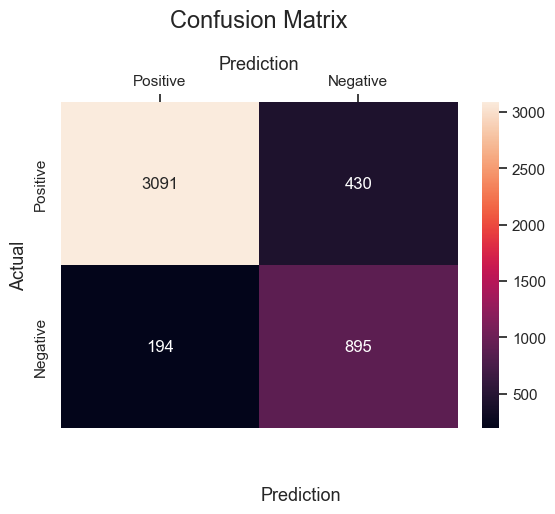

In [122]:
cm = confusion_matrix(y_true,y_pred_thresh)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

# **Conclusiones Finales**

Los modelos obtuvieron resultados similares, pero el XGBoost fue el que tuvo el mejor promedio. Aun con dificultades para predecir los positivos, probablemente por el desbalance en los datos.

Se podría utilizar metodos como Easy Data Augmentation (EDA), como reemplazo de sinonimos, random insertion, swap, y deletion para aumentar la performance en la clasifiacion de los textos.
Tambien se podrian utilizar modelos como BERT, que tienen mayor consideracion en el contexto.

Se puede predecir con cierta precisión el sentimiento de las nuevas reviews que van ingresando a las plataformas, con el fin de categorizarlas y obtener así un insight mayor, sobre la experiencia de usuario y los puntos clave que son valorados o criticados.

En el futuro se podría utilizar mas variables numéricas como value_for_money, ground_service, cabin_staff_service, seat_comfort, seat_comfort para darle mayor detalle y precisión al entrenamiento del modelo.

In [123]:
print(dbert_report)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3521
           1       0.68      0.82      0.74      1089

    accuracy                           0.86      4610
   macro avg       0.81      0.85      0.82      4610
weighted avg       0.88      0.86      0.87      4610



In [124]:
print(xgb_report)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3509
           1       0.48      0.45      0.47      1102

    accuracy                           0.75      4611
   macro avg       0.66      0.65      0.65      4611
weighted avg       0.75      0.75      0.75      4611



In [125]:
print(rf_report)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      3509
           1       0.59      0.81      0.68      1102

    accuracy                           0.82      4611
   macro avg       0.76      0.82      0.78      4611
weighted avg       0.85      0.82      0.83      4611



In [127]:
print(rl_report)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3509
           1       0.61      0.83      0.70      1102

    accuracy                           0.83      4611
   macro avg       0.77      0.83      0.79      4611
weighted avg       0.86      0.83      0.84      4611

